# Extract protein features using VQ-VAE
・全細胞のデータを用いるとOS errorが出るので、少しでもメモリを節約するためにLocal変数に書き換える

In [4]:
import torch
import random
import pickle
import os
import sys
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split

# Import the required files
# sys.path.insert(1, '../download/VAE/codes_target/')
import utils_vq_vae_target, VQ_VAE_target, train_vq_vae_target
from utils_vq_vae_target import *
from VQ_VAE_target import *
from train_vq_vae_target import *

# Seed for reproduction
np.random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)


# =================================================================================
# Protein signatures.
# =================================================================================
parser = argparse.ArgumentParser()

# Perturbation type.
parser.add_argument(
    '--pert_type', type=str, 
#     default='trt_sh.cgs', 
    default = 'trt_oe',
    help='Perturbation type of protein signatures, e.g., trt_sh.cgs or trt_oe'
)

# Cell line.
parser.add_argument(
    '--cell_name', type=str, 
#     default='All',
#     default='AllCell', 
    default='AllCellParallel',
    help='Cell name, e.g., All: averaged data, AllCell: all signatures measured in all cell lines, AllCellParallel'
)

# Gene scaling.
parser.add_argument(
    '--gene_scaling', type=str, 
    default='MaxAbs', 
#     default='Orig',
    help='Gene scaling, e.g., when not scaling, Orig or when scaling, Std, Cent or MaxAbs'
)

# Select Cell lines based on missing rates.
parser.add_argument(
    '--cell_missing_rate', type=float, 
    default=0.1,
    help='Threshold of missing rates of cell lines when selecting AllCellParallel as --cell_name'
)

# Signature path.
parser.add_argument(
    '--gene_expression_file', type=str, default='../../../LINCS/latest_version/imputation/imputed_data/', 
    help='Path of the training gene expression profile dataset for the VQ-VAE'
)

#===========================================================
# Hyperparameters
#===========================================================
# Training epochs default= 500
parser.add_argument('--gene_epochs', type=int, default=60, help='VQ-VAE training epochs') # Training epochs default= 500

# Length of gene expression signatures.
parser.add_argument('--gene_num', type=int, default=978, help='Number of gene values')

# Lyer size of VQ-VAE encoder (978 -> 1000 -> 512 -> 256)
parser.add_argument('--gene_emb_dim', type=int, 
                    default=[256, 128, 512, 256], 
#                     default=[512, 256, 1024, 256], 
#                     default=[512, 1024, 256], 
#                     default=[1000, 512, 256], 
                    help='Lyer size of VQ-VAE encoder') #  (978 -> 1000 -> 512 -> 256)

# Number of embedding representations (codebook)
parser.add_argument('--gene_num_emb', type=int, 
                    default=128, 
                    help="Number of embedding representations (codebook)") 

# Commitment cost for VQ-VAE
parser.add_argument('--gene_com_cost', type=float, default=0.25, help='Commitment cost for VQ-VAE')

# Batch size
parser.add_argument('--gene_batch_size', type=int, default=64, help='Batch size for training VQ-VAE')

# Learning rate of VQ-VAE model (Default: 2e-3)
parser.add_argument('--gene_lr', type=float, 
#                     default=2e-3,
                    default=2e-4, 
                    help='Learning rate of VQ-VAE, Default: 2e-3')

# Activation function.
parser.add_argument('--gene_activation_fn', type=str, 
                    default='LeakyReLU0.5', 
#                     default='SELU', 
#                         default='Tanh',
                    help='Activation function: Tanh, ReLU or SELU') # Revise: ReLU -> Tanh

# Gene dropout.
parser.add_argument('--gene_dropout', type=float, default=0.1, 
                    help='Dropout probability') # Revise: 0.2 -> 0.1


#===========================================================
# File paths
#===========================================================
parser.add_argument('--saved_gene_vae', type=str, default='saved_vq_vae', help='Save the trained VQ-VAE')

parser.add_argument('--gene_vae_train_results', type=str, default='vq_vae_train_results.csv', 
                    help='Path to save the results of trained VQ-VAE')

parser.add_argument('--one_gene_density_figure', type=str, default='one_gene_density_figure.png', 
                    help='Path to save the density figures of gene data')

parser.add_argument('--all_gene_density_figure', type=str, default='all_gene_density_figure.png', 
                    help='Path to save the density figures of gene data')

# args = parser.parse_args()
args = parser.parse_args(args=[])


#===========================================================
# Print GeneVAE hyperparameter information
#===========================================================
show_gene_vae_hyperparamaters(args)



VQ-VAE Hyperparameter Information:
PROFILE_TYPE:   trt_oe
GENE_EXPRESSION_FILE:   ../../../LINCS/latest_version/imputation/imputed_data/
CELL_NAME:   AllCellParallel
GENE_EPOCHS:   60
GENE_LR:   0.0002
GENE_NUM:   978
GENE_EMB_DIM:   [256, 128, 512, 256]
GENE_NUM_EMB:   128
GENE_BATCH_SIZE:   64
GENE_DROUPOUT:   0.1
GENE_ACTIVATION_FUNCTION:   LeakyReLU0.5


In [20]:
# Train GeneVAE for representation learning of gene expression profiles
trained_vq_vae = train_vq_vae(args)
# Note that the VQ-VAE was trained 10 epochs (default: 500 epochs) 

Selected cell lines: 10
Training Information:
Epoch 1,  recon_error: 0.013, vq_loss: 0.000, total_loss: 0.013
Epoch 2,  recon_error: 0.013, vq_loss: 0.000, total_loss: 0.013
Epoch 3,  recon_error: 0.012, vq_loss: 0.000, total_loss: 0.013
Epoch 4,  recon_error: 0.012, vq_loss: 0.000, total_loss: 0.013
Epoch 5,  recon_error: 0.012, vq_loss: 0.000, total_loss: 0.013
Epoch 6,  recon_error: 0.012, vq_loss: 0.001, total_loss: 0.013
Epoch 7,  recon_error: 0.012, vq_loss: 0.001, total_loss: 0.013
Epoch 8,  recon_error: 0.012, vq_loss: 0.001, total_loss: 0.013
Epoch 9,  recon_error: 0.012, vq_loss: 0.001, total_loss: 0.013
Epoch 10,  recon_error: 0.012, vq_loss: 0.001, total_loss: 0.013
Epoch 11,  recon_error: 0.012, vq_loss: 0.001, total_loss: 0.013
Epoch 12,  recon_error: 0.012, vq_loss: 0.001, total_loss: 0.013
Epoch 13,  recon_error: 0.012, vq_loss: 0.002, total_loss: 0.013
Epoch 14,  recon_error: 0.012, vq_loss: 0.002, total_loss: 0.014
Epoch 15,  recon_error: 0.012, vq_loss: 0.002, total_

Load the trained VQ-VAE.
../data/VQ_VAE/trt_oe/CellLine_AllCellParallel/Epo60_Lr0.0002_Hid1024_512_256_256_Lat128_Bat64_Comc0.25_Dro0.1_ActLeakyReLU0.5_Missing0.1_ScaleMaxAbs/saved_vq_vae.pkl
Selected cell lines: 10


/Users/nanbasatoko/Documents/target_repositioning4/VAE/scr_VQ_VAE_target/utils_vq_vae_target.py:438: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplots(figsize=(12,7))


Gene expression profile distribution is created.


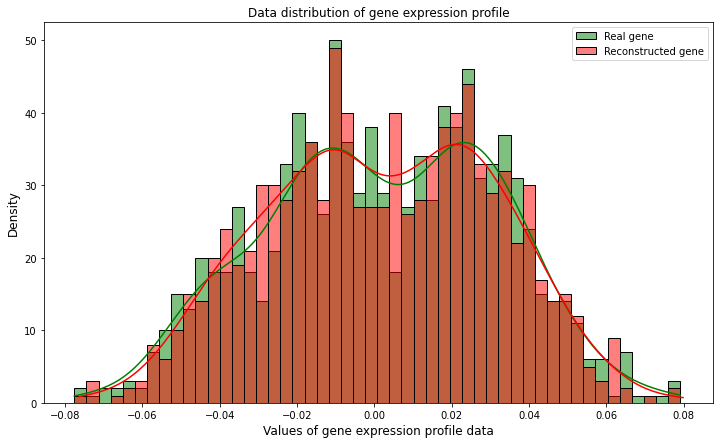

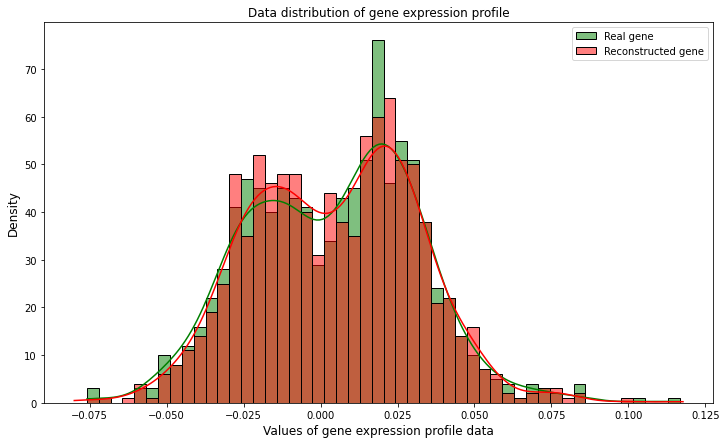

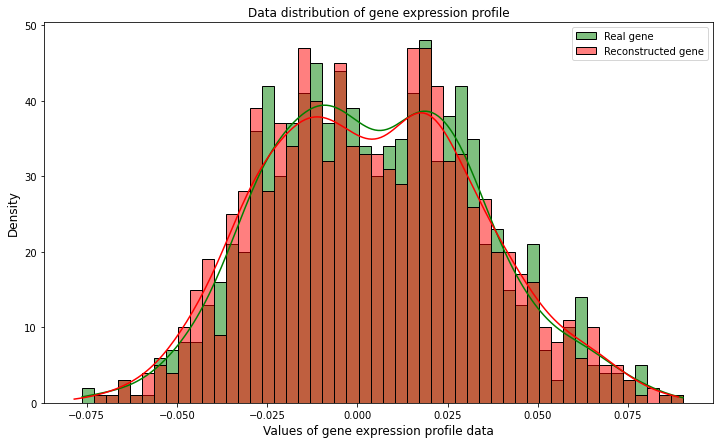

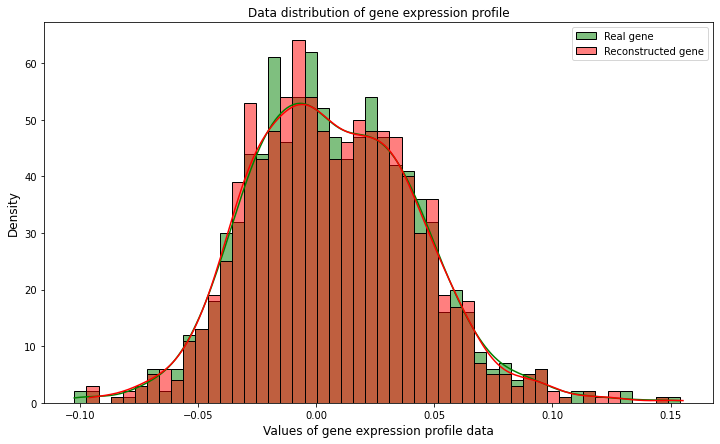

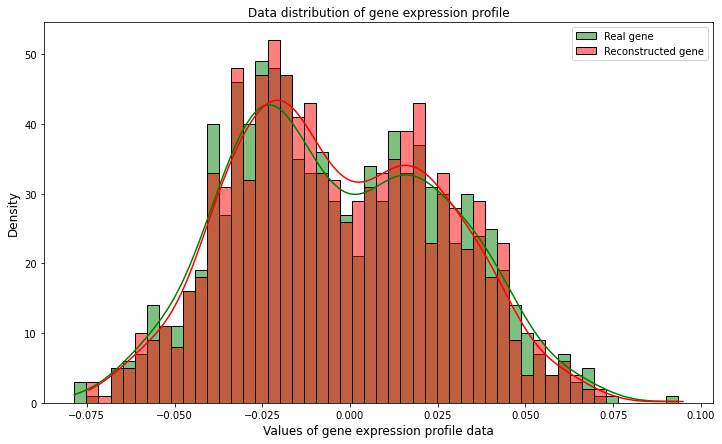

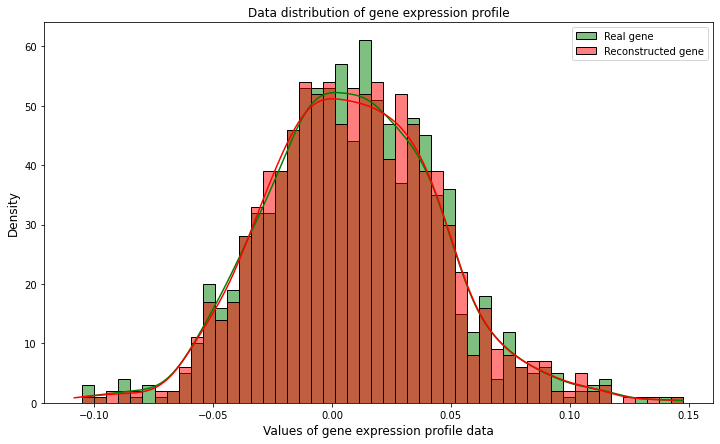

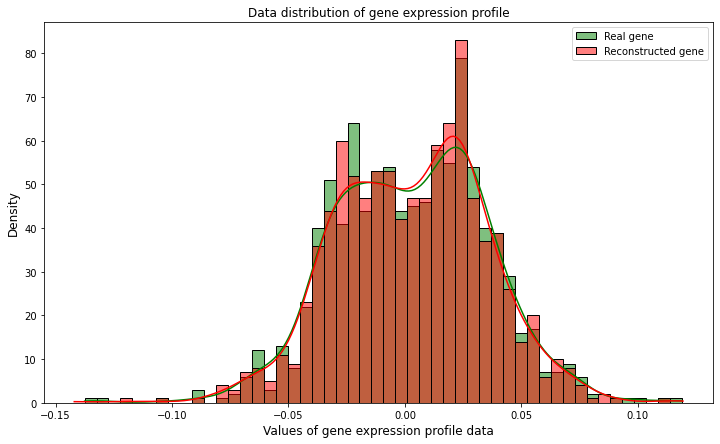

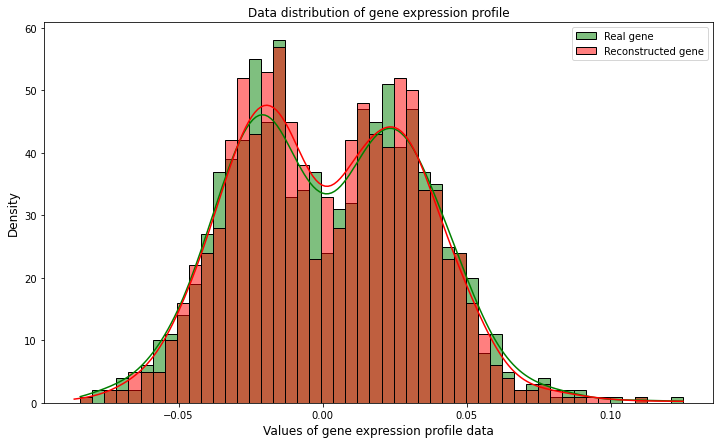

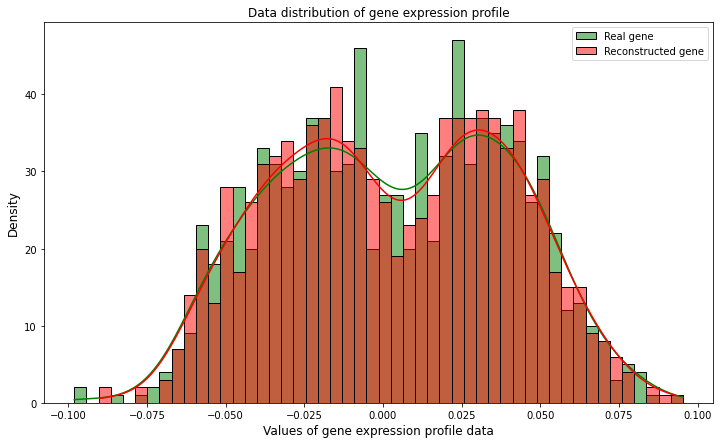

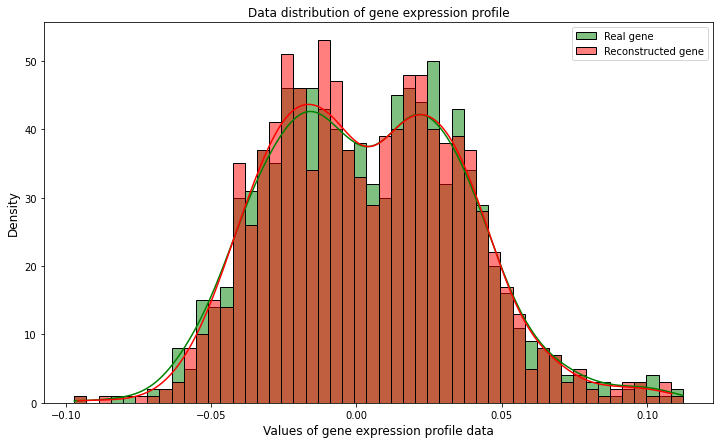

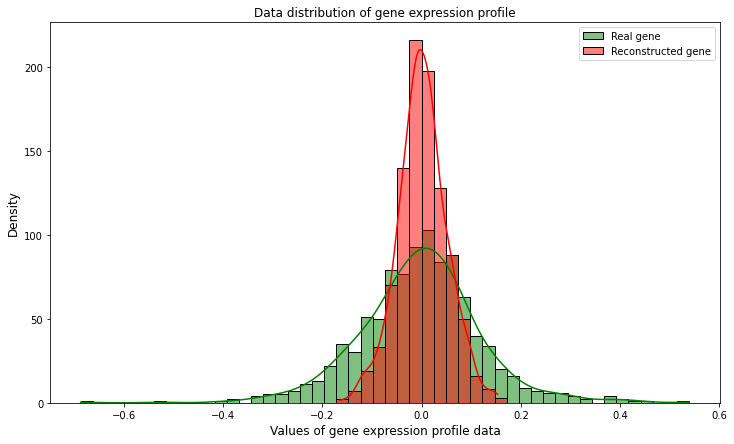

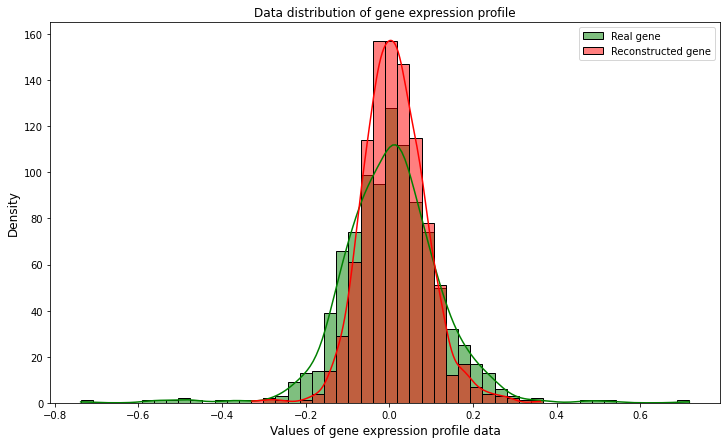

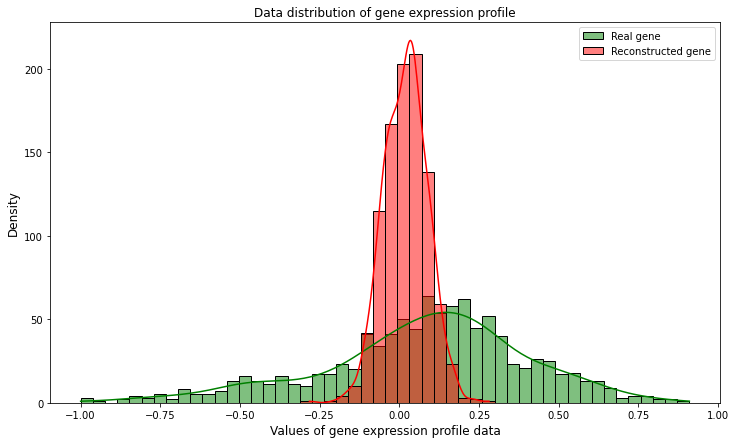

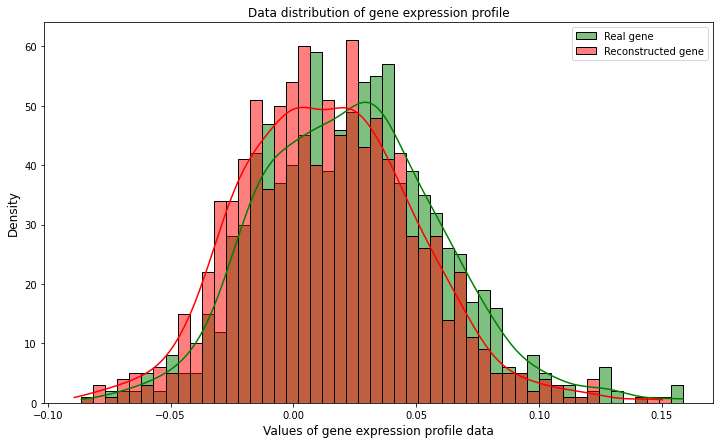

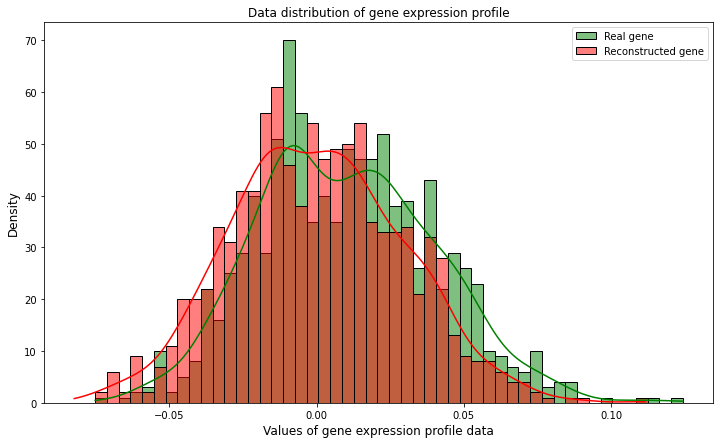

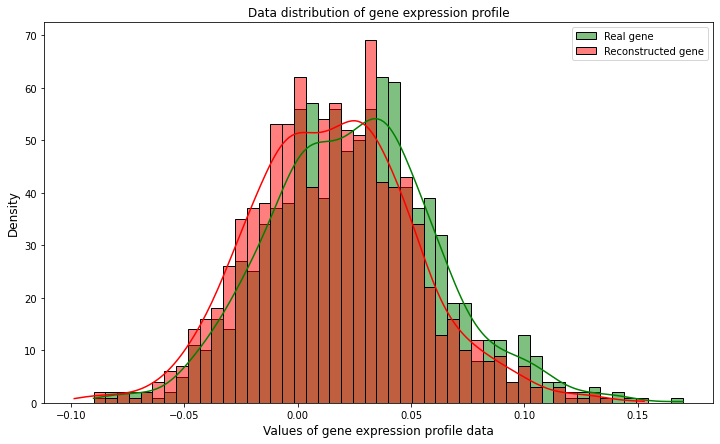

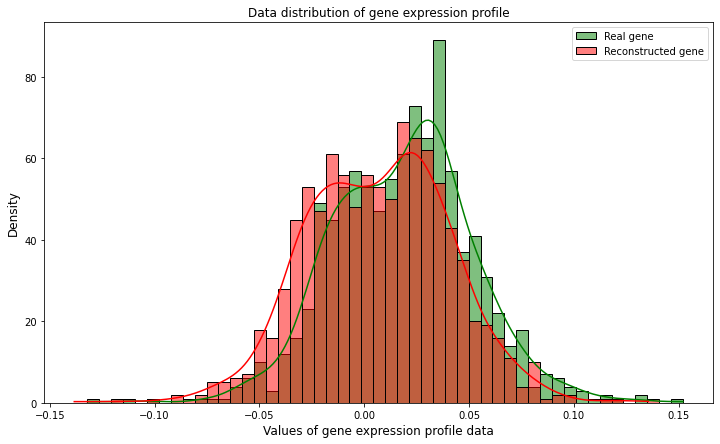

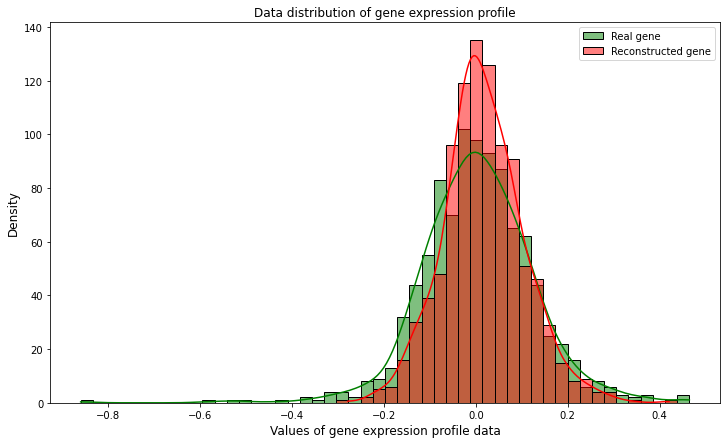

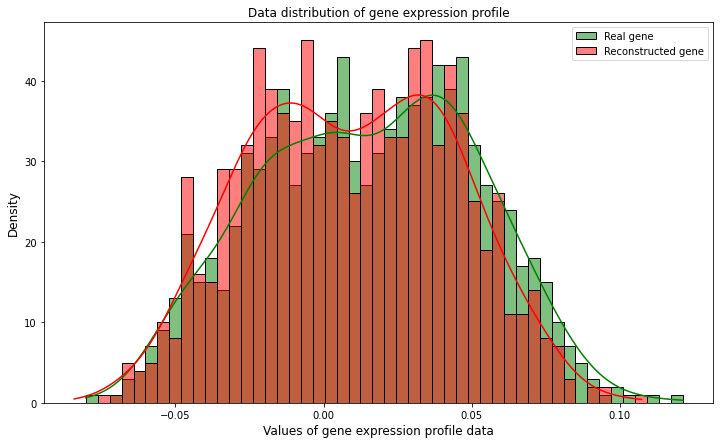

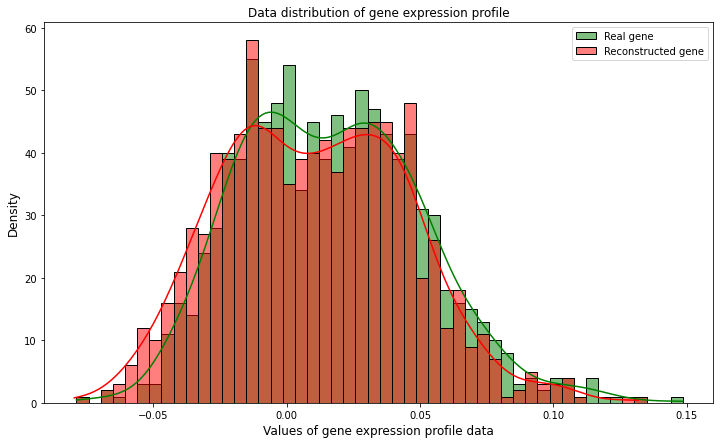

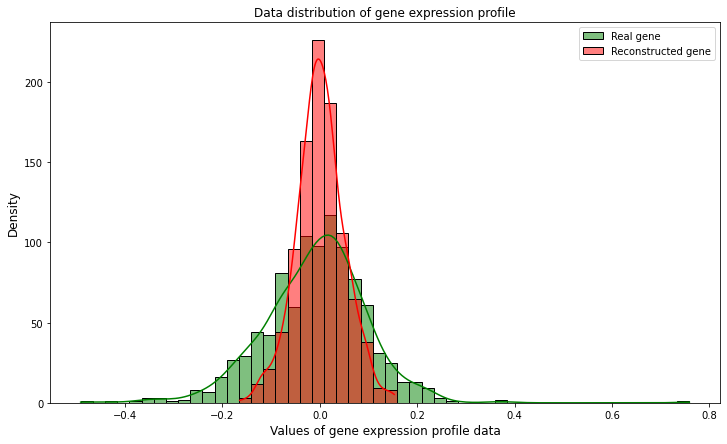

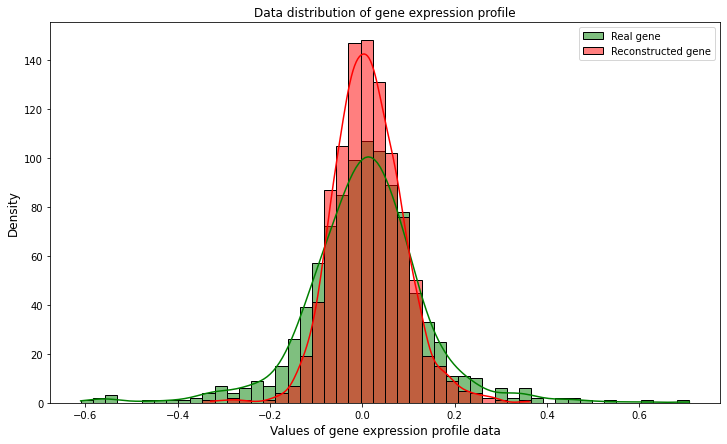

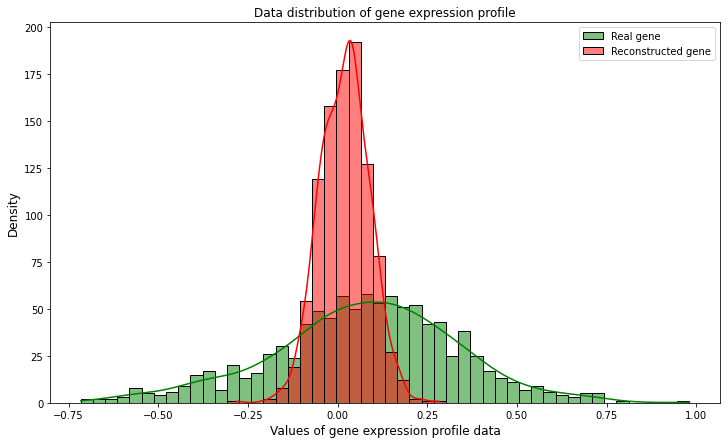

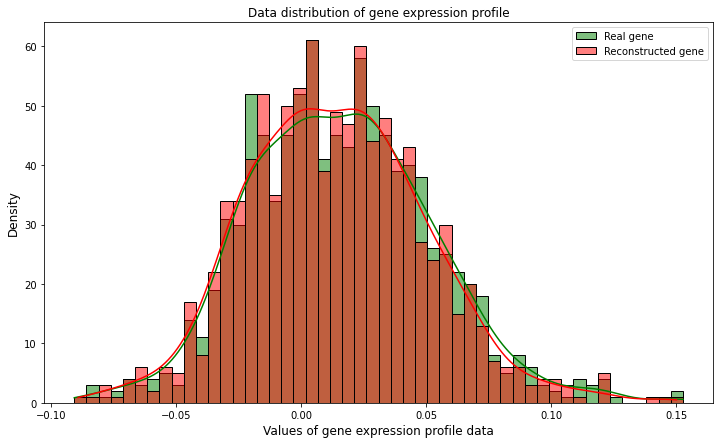

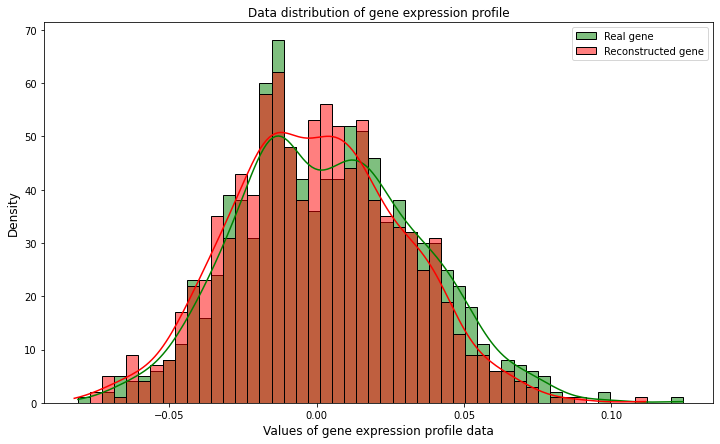

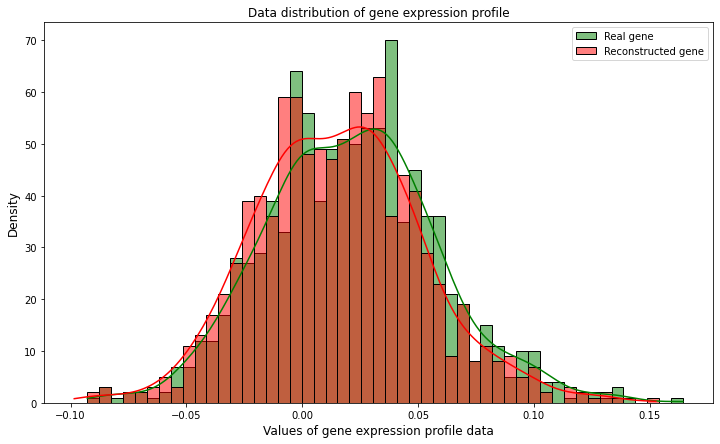

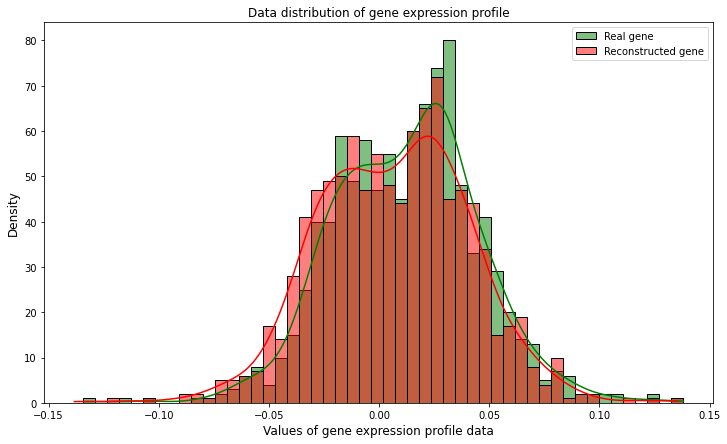

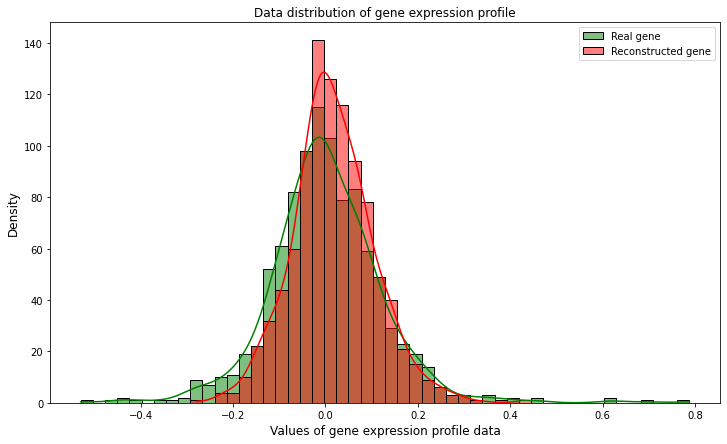

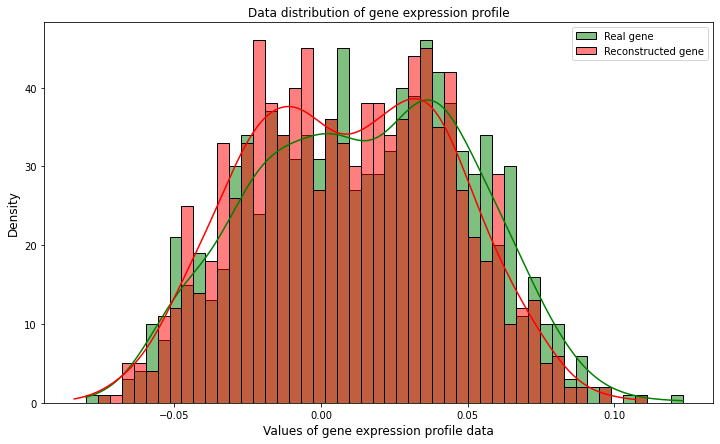

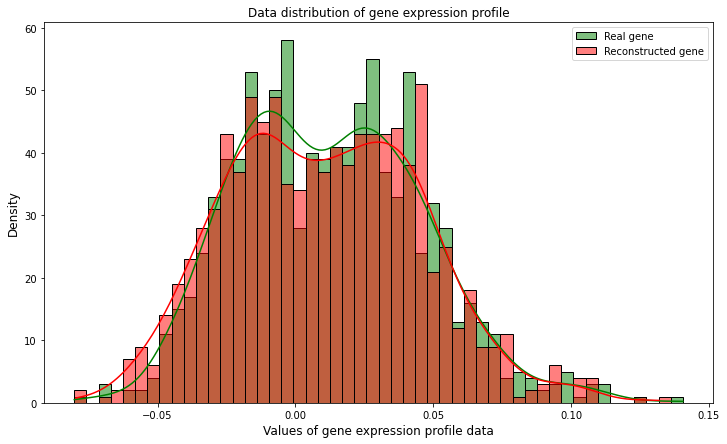

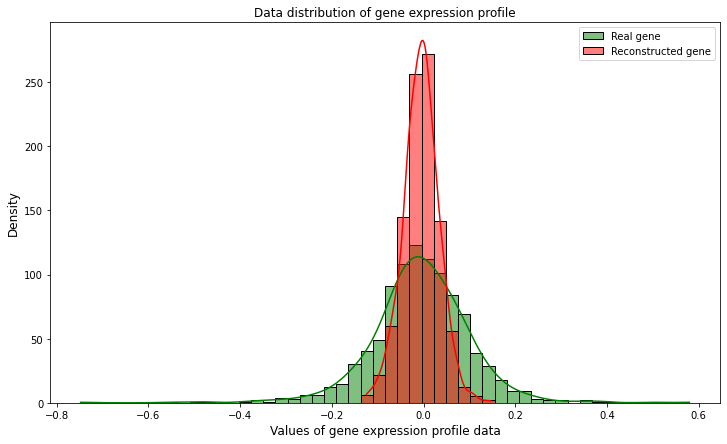

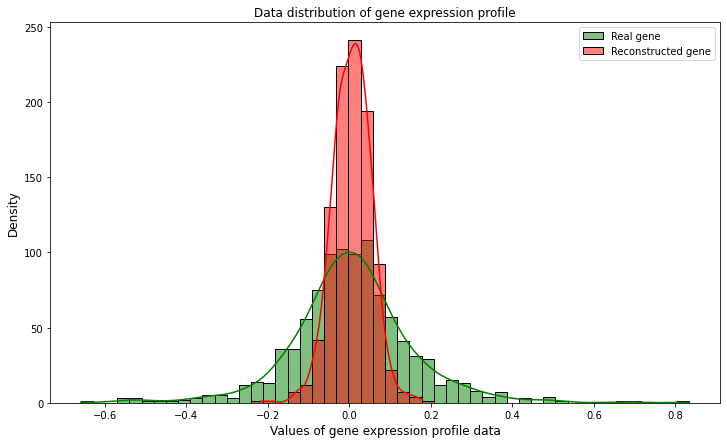

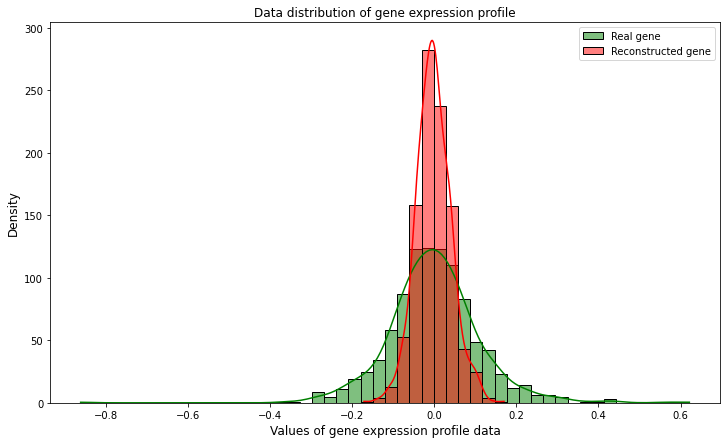

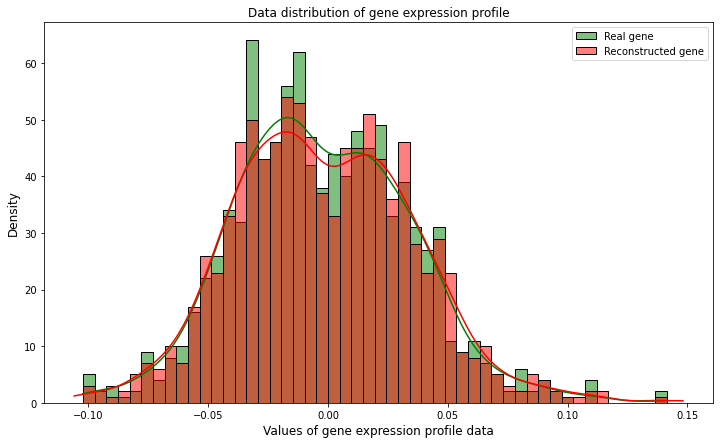

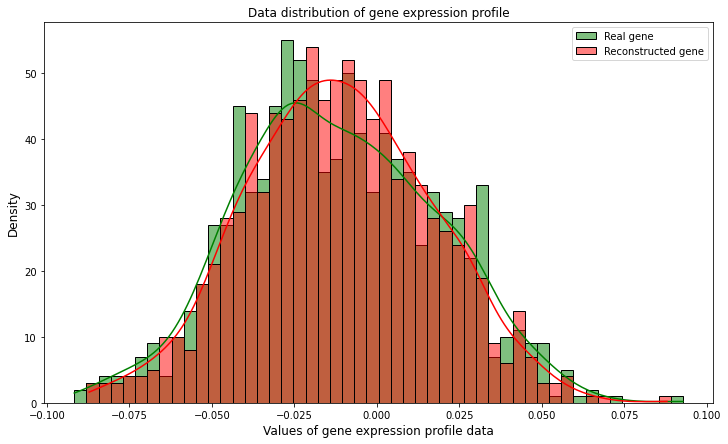

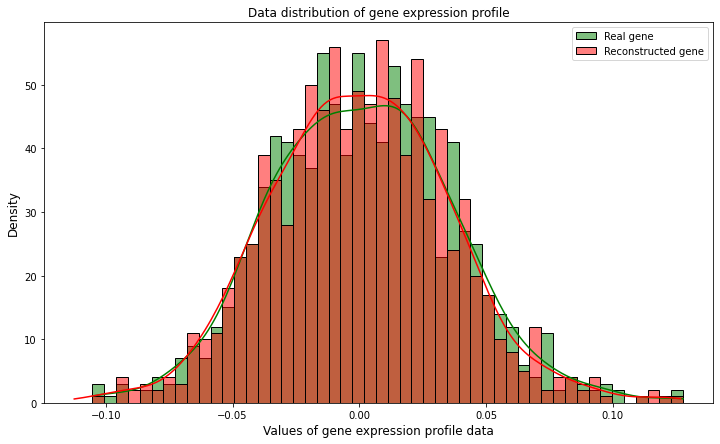

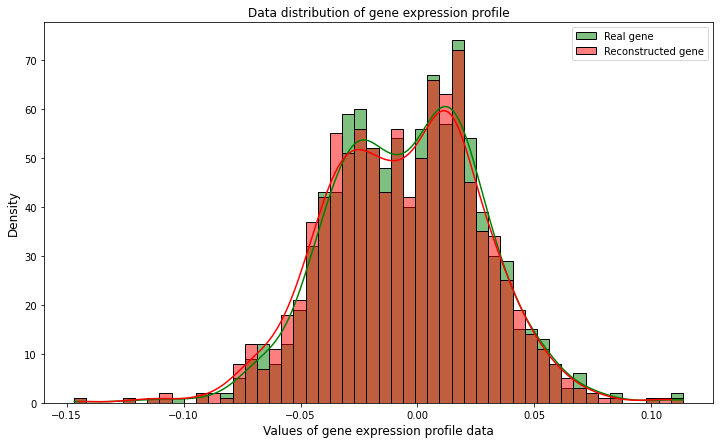

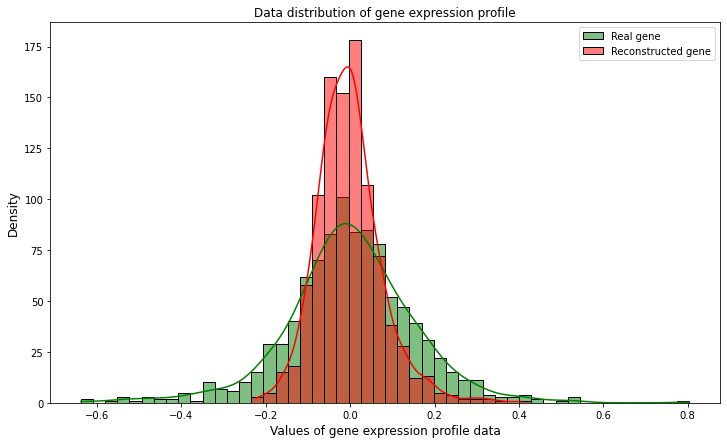

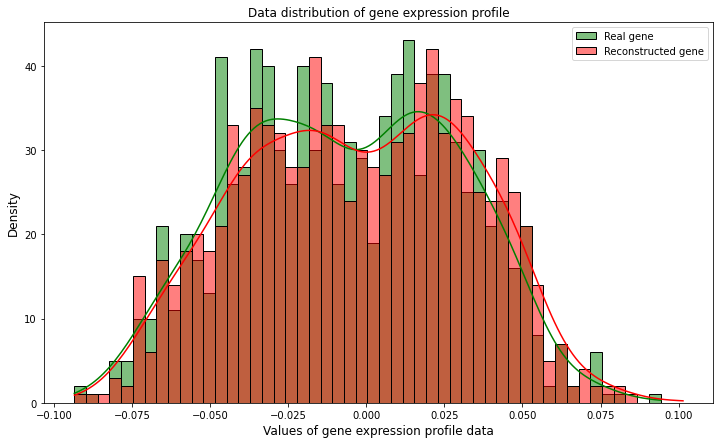

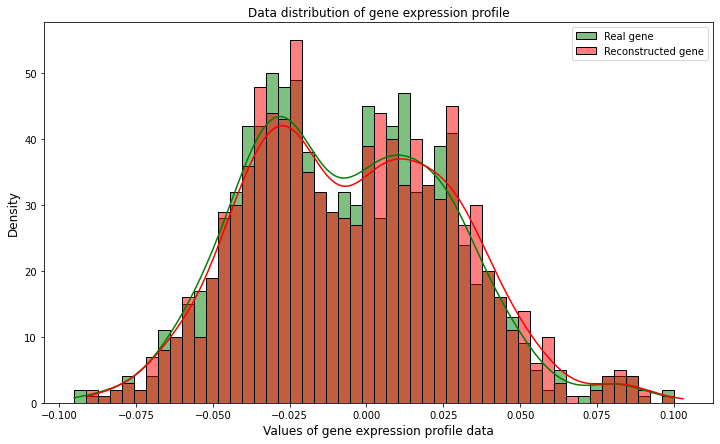

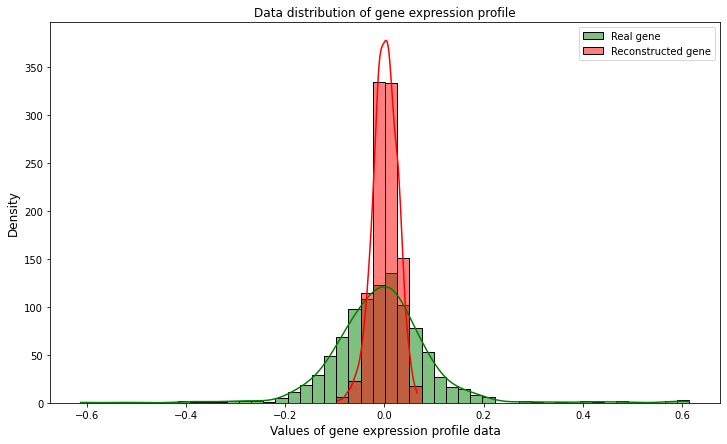

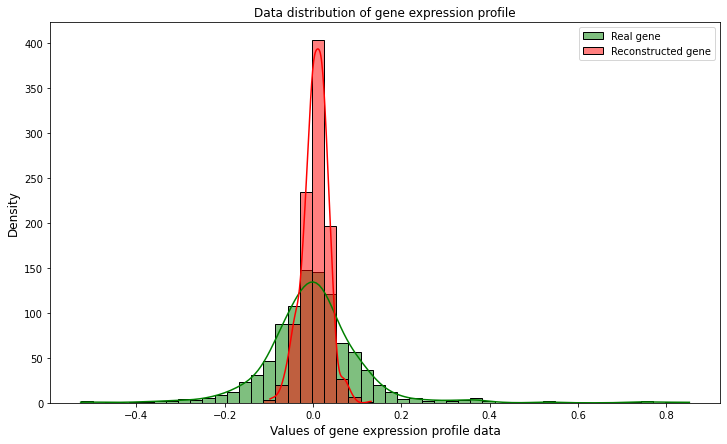

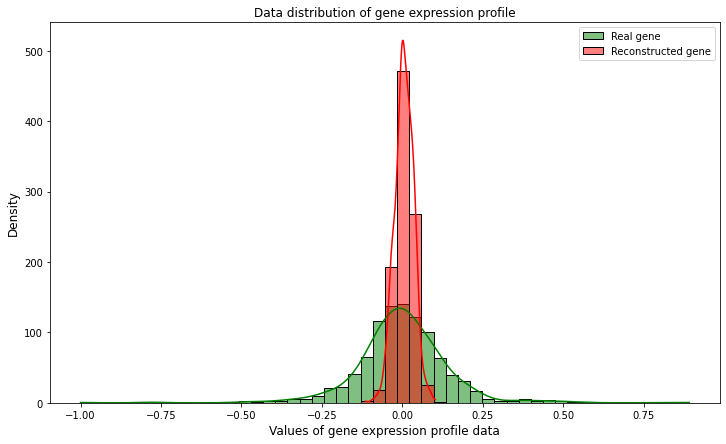

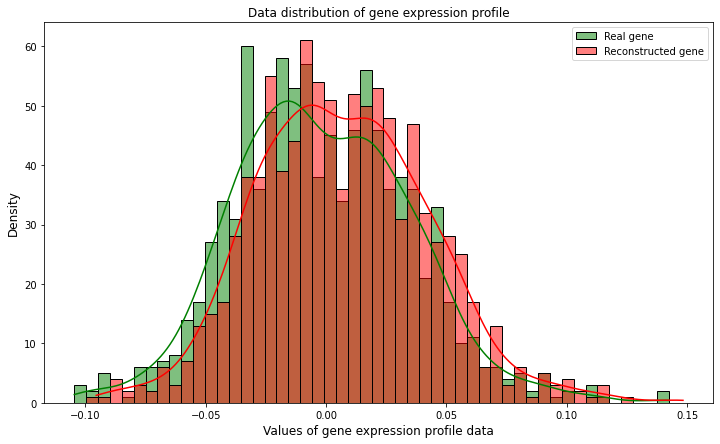

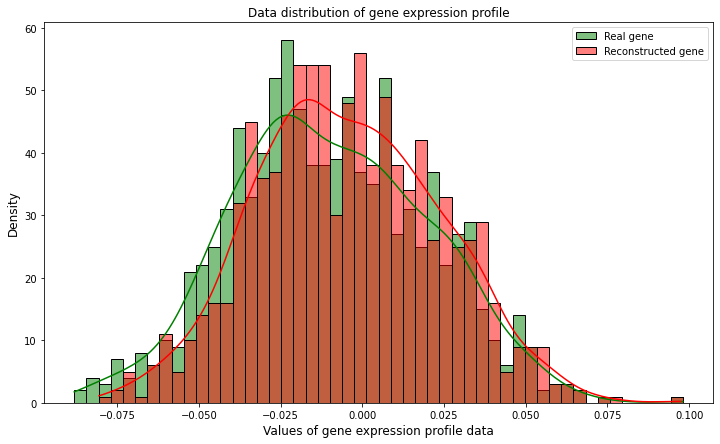

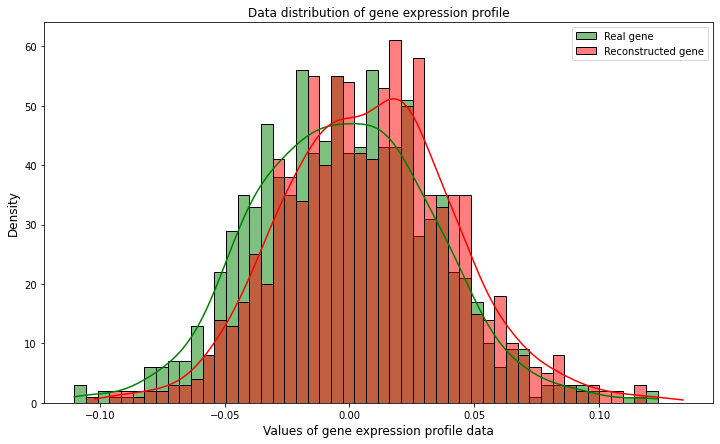

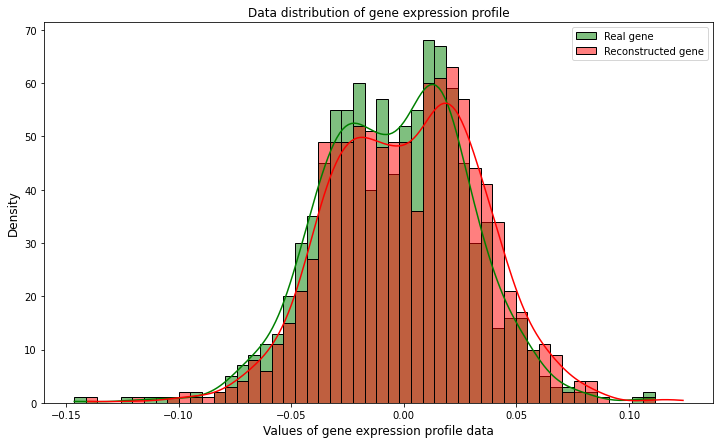

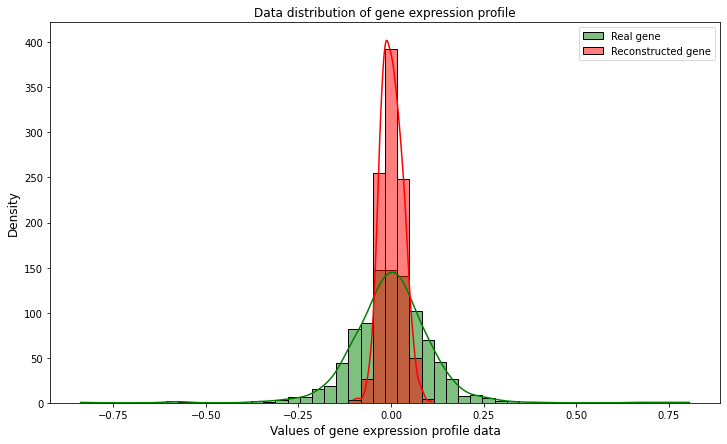

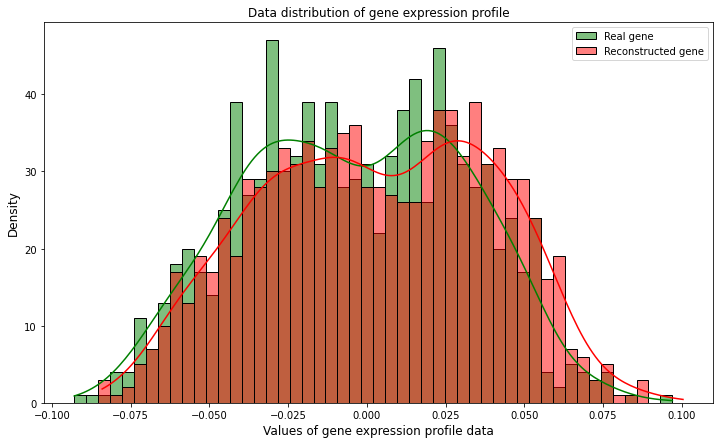

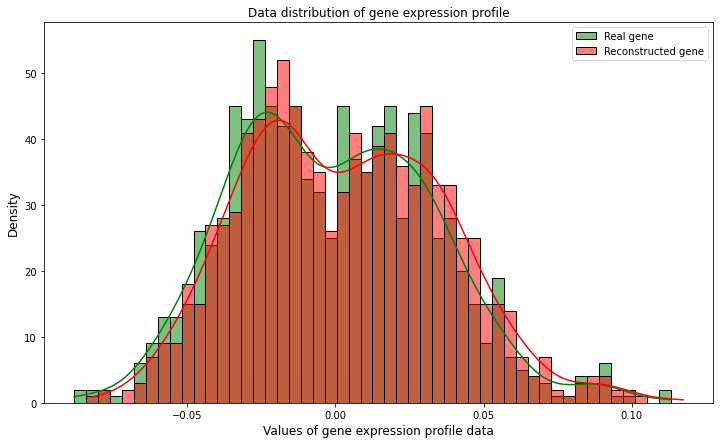

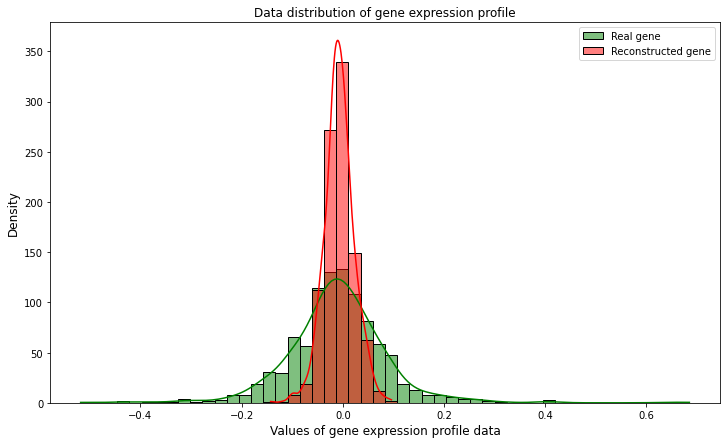

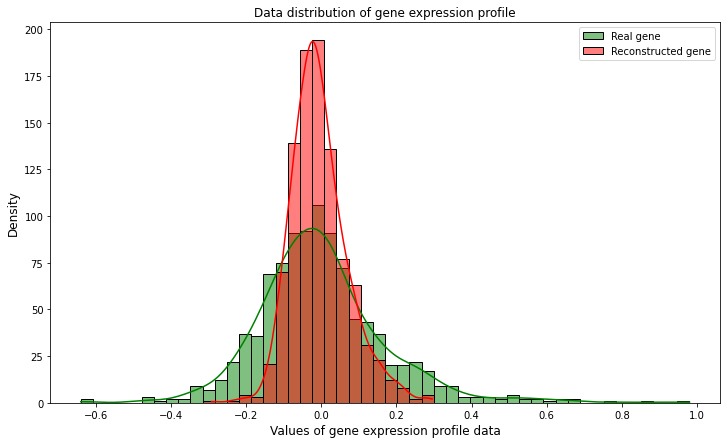

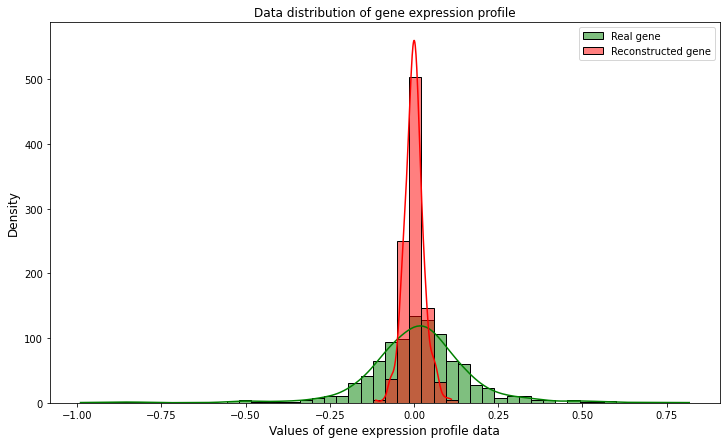

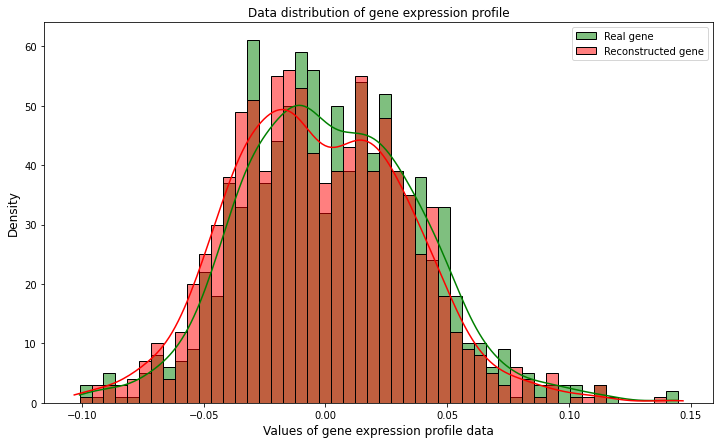

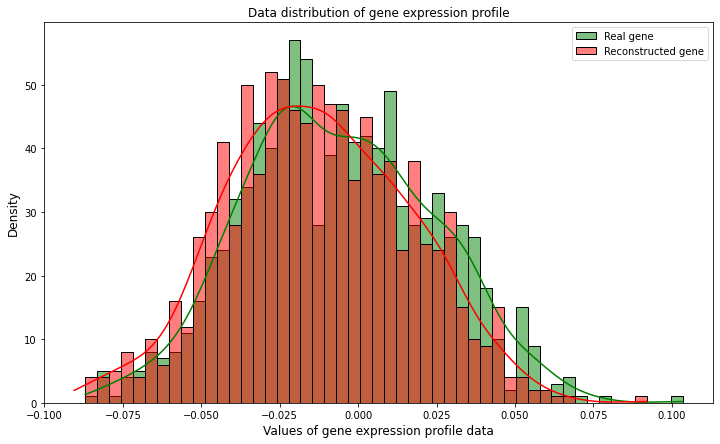

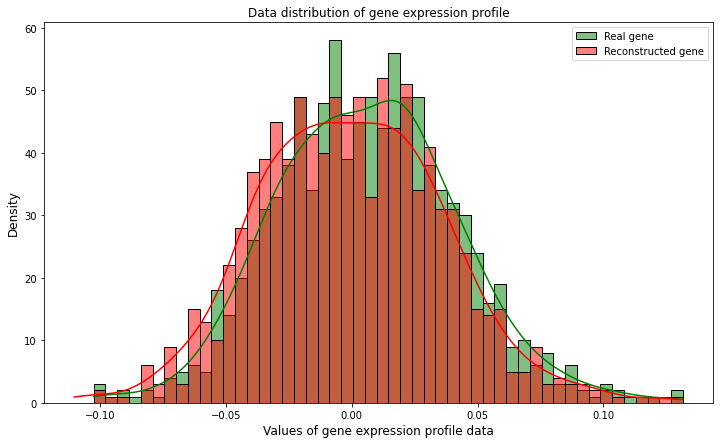

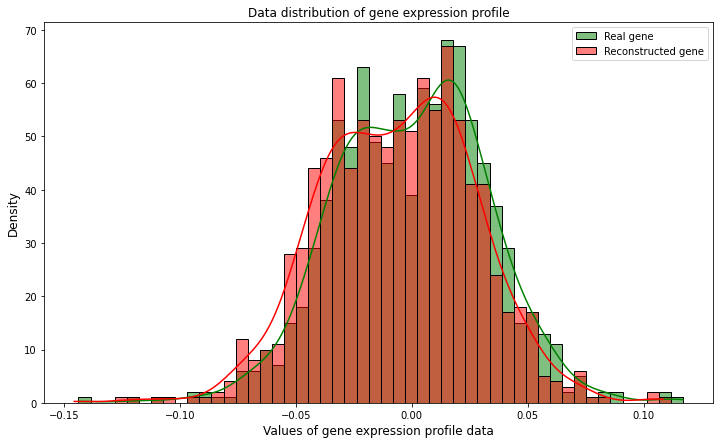

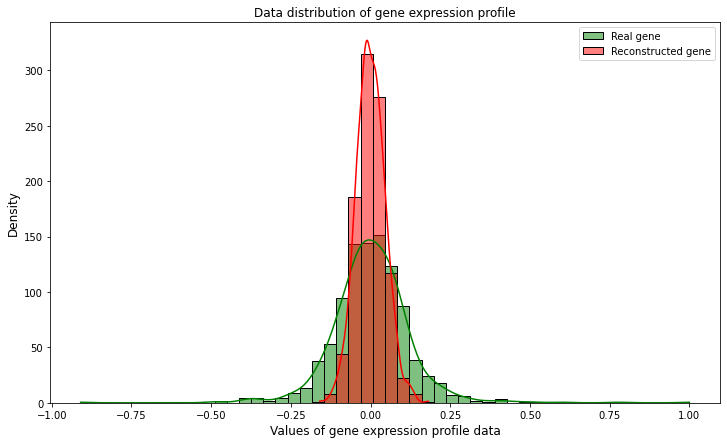

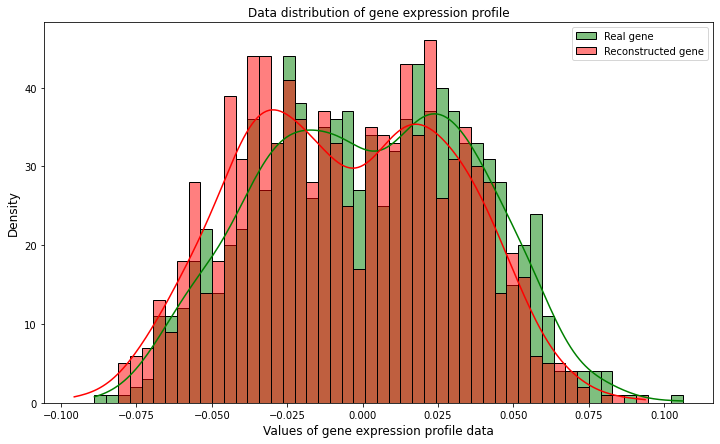

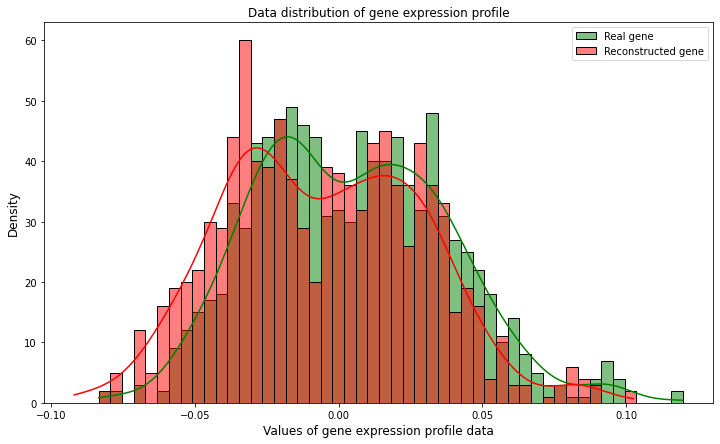

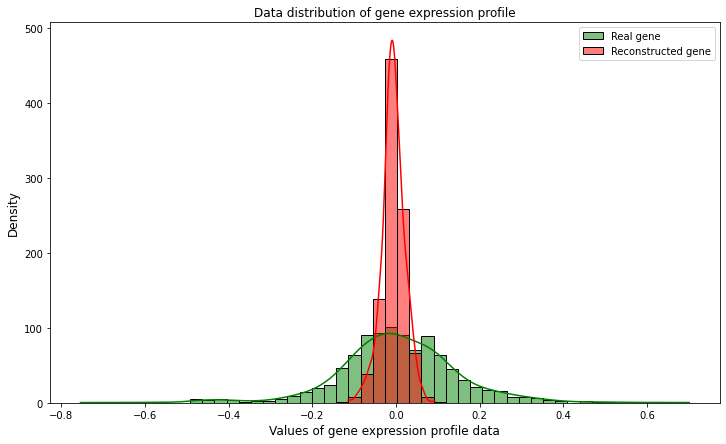

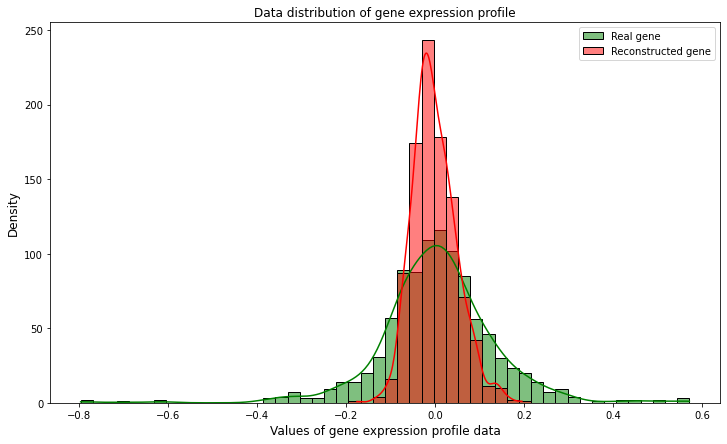

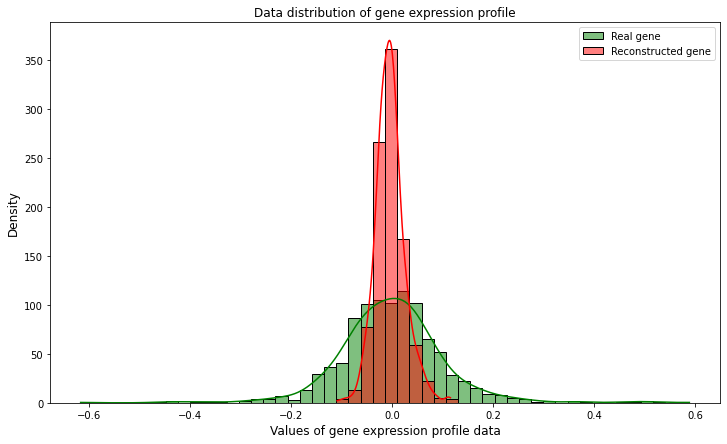

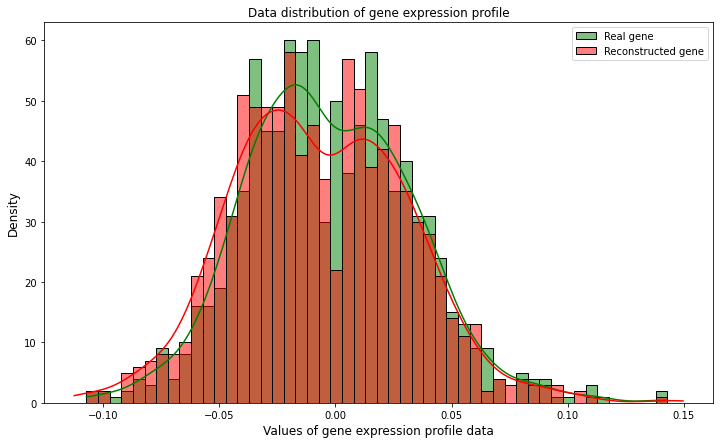

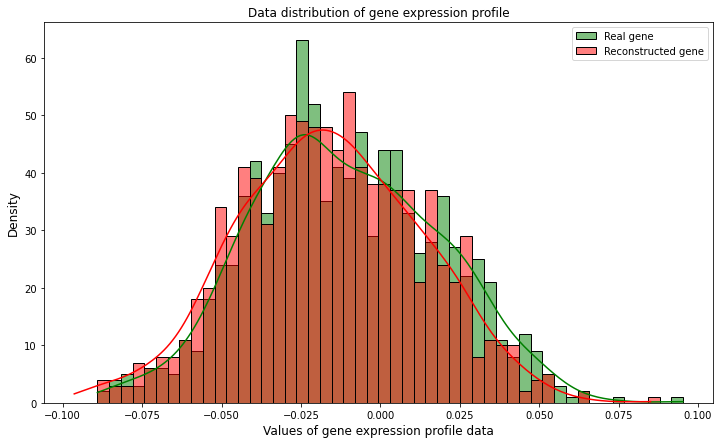

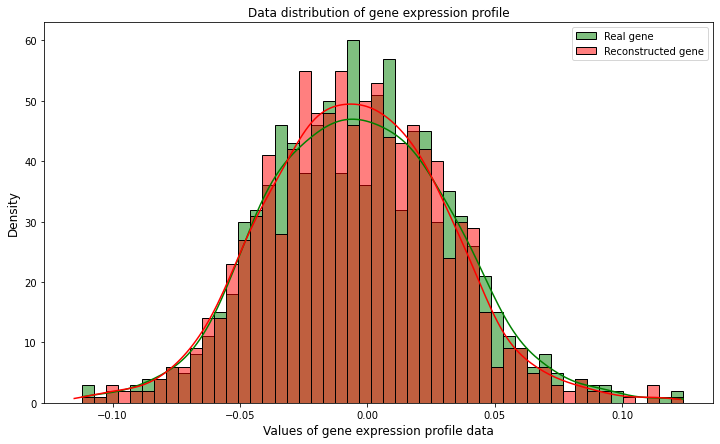

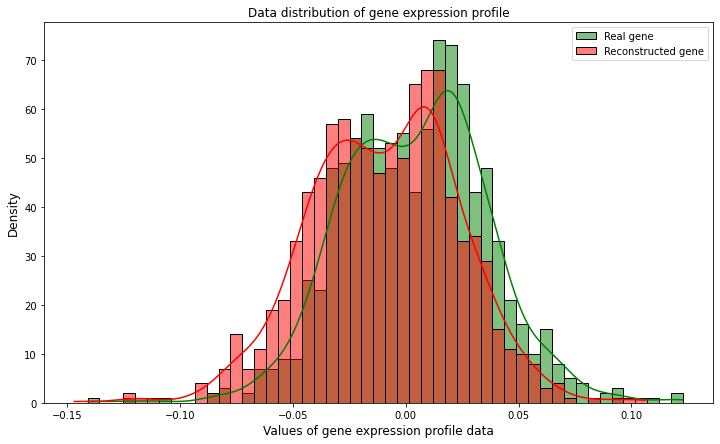

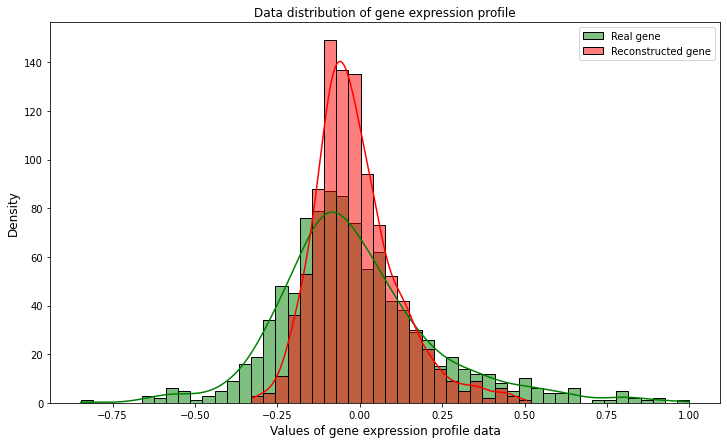

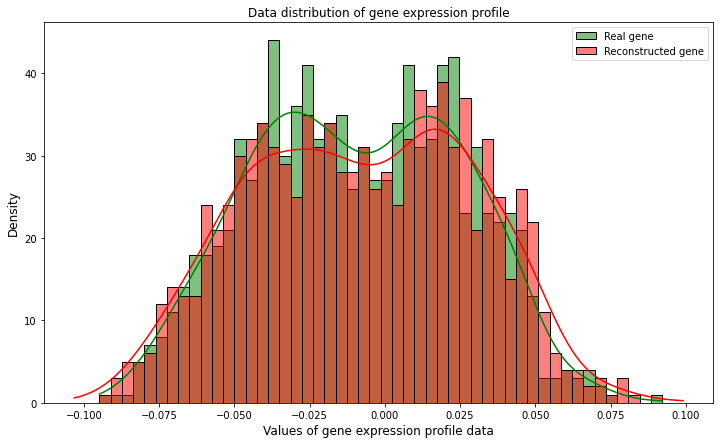

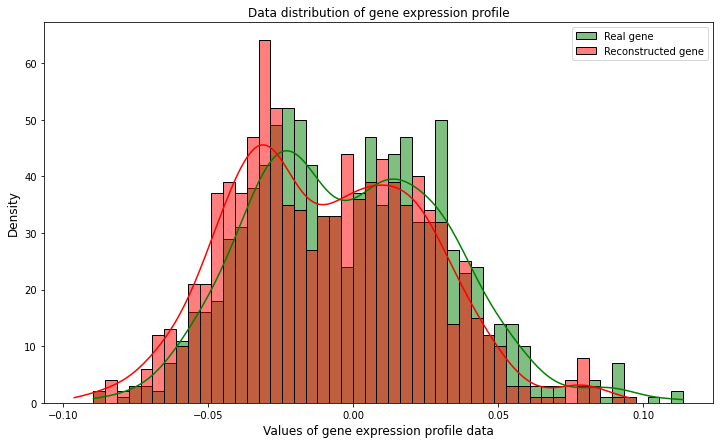

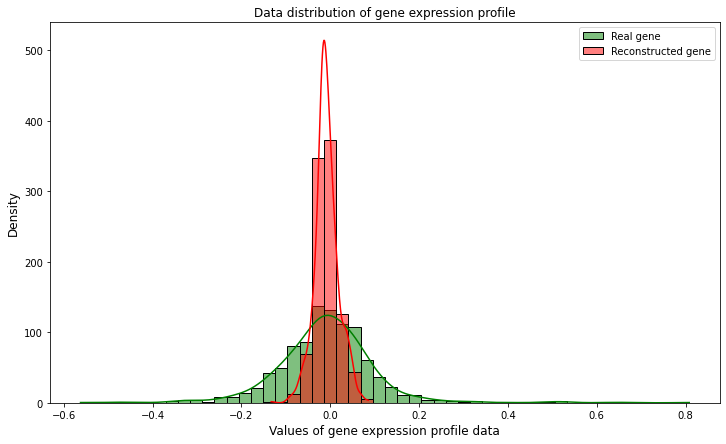

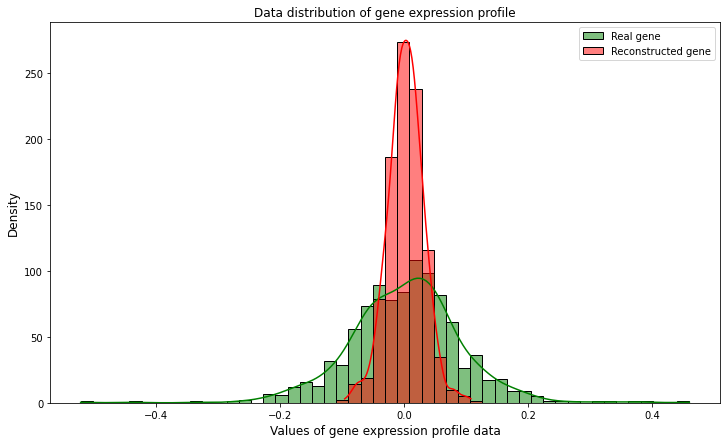

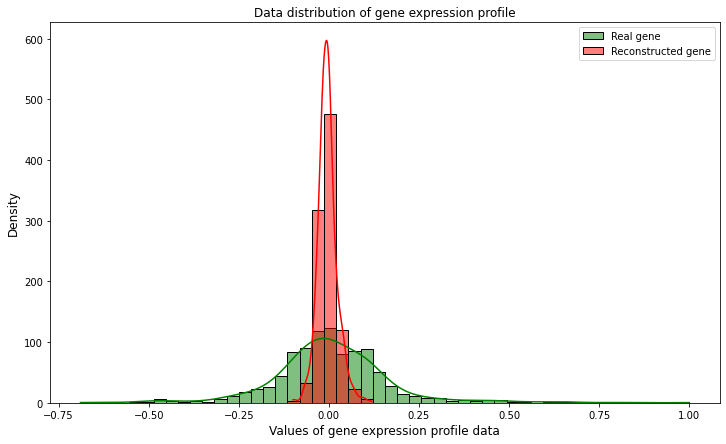

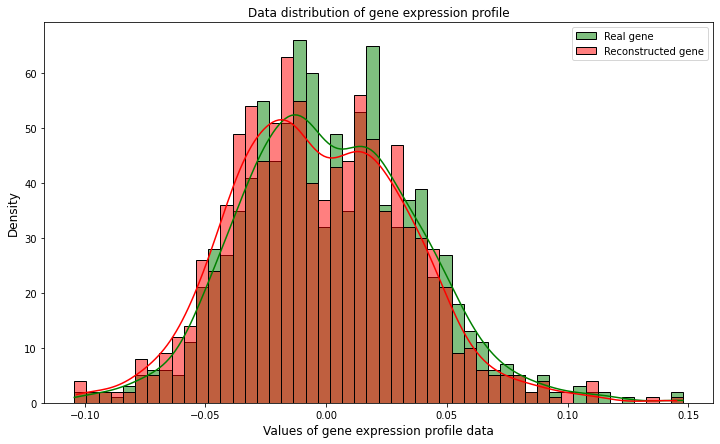

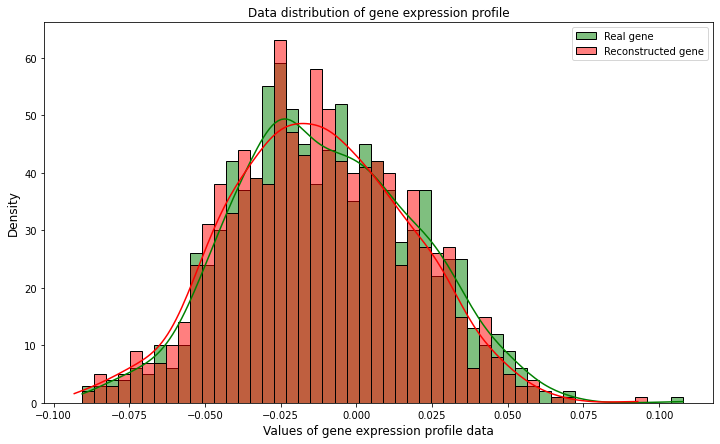

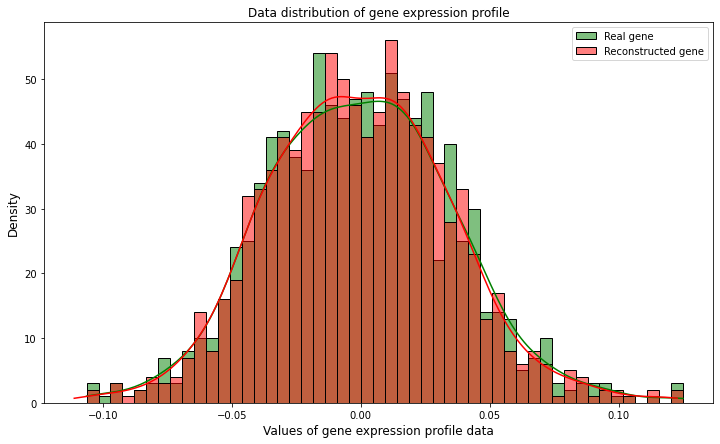

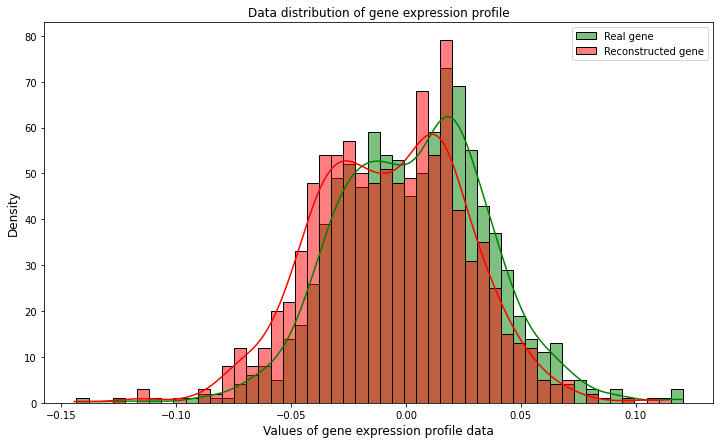

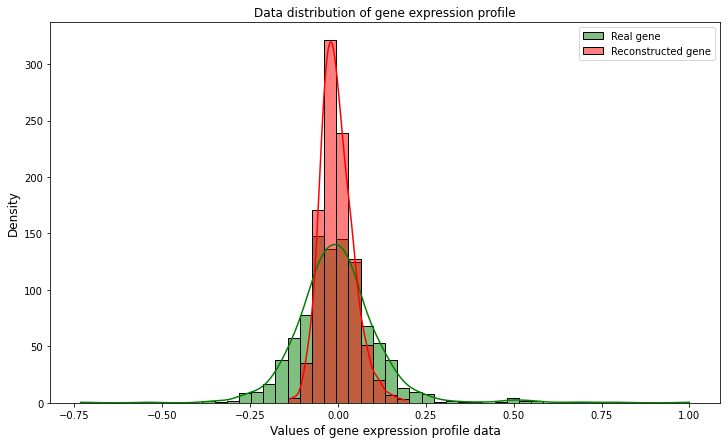

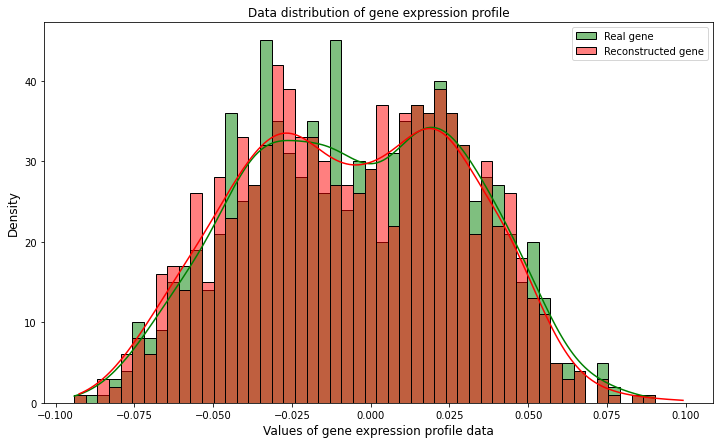

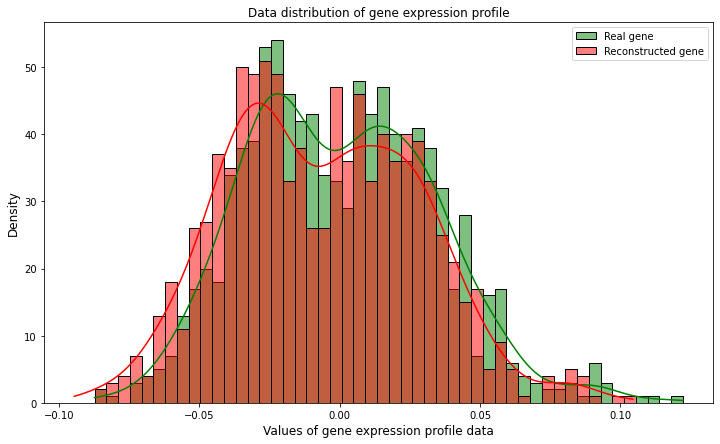

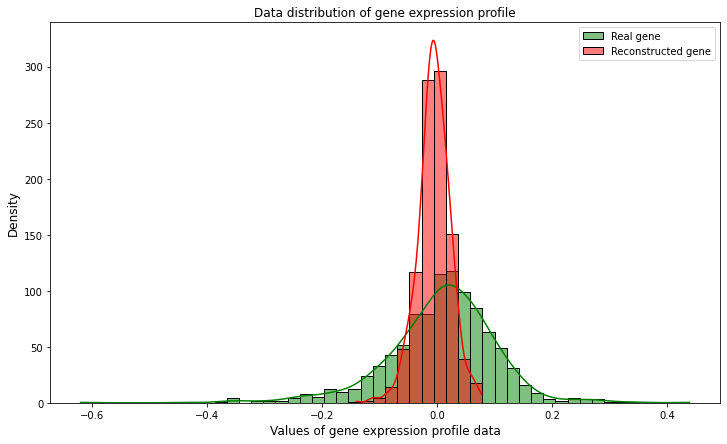

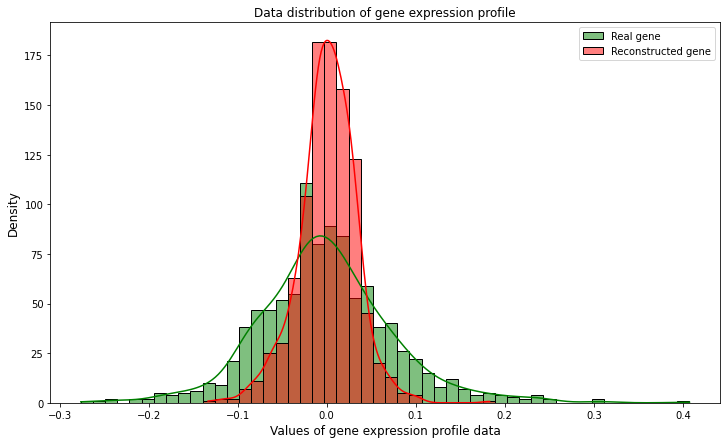

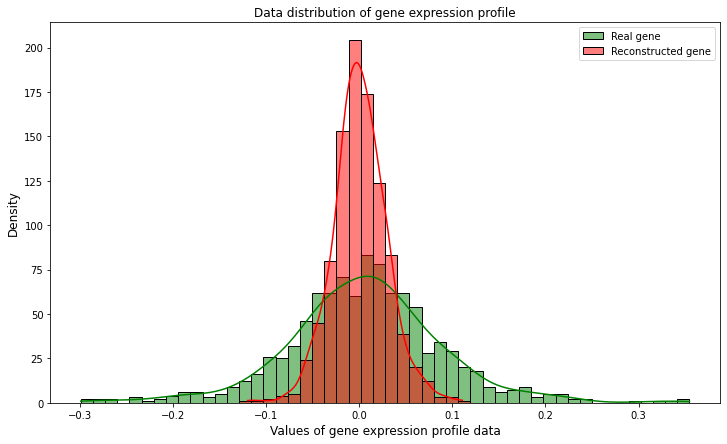

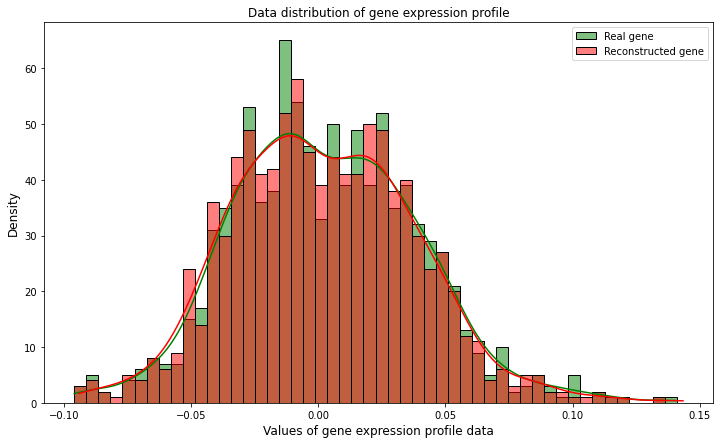

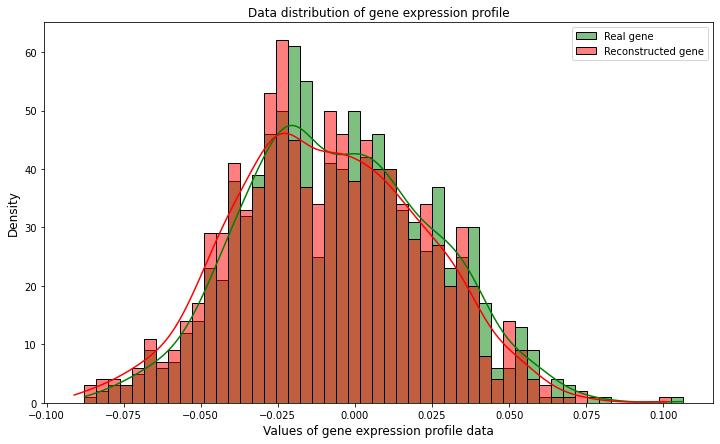

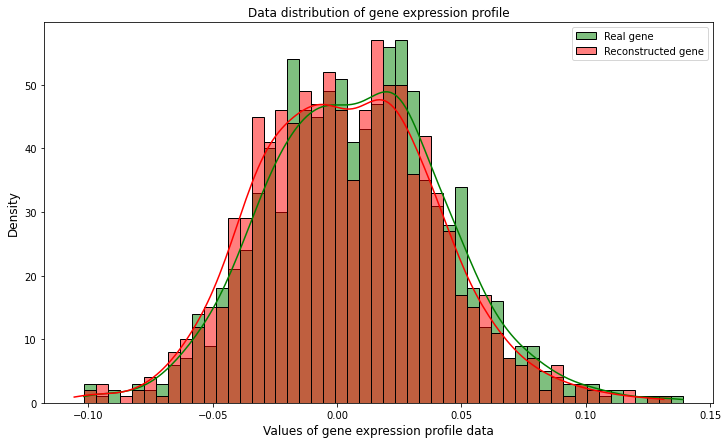

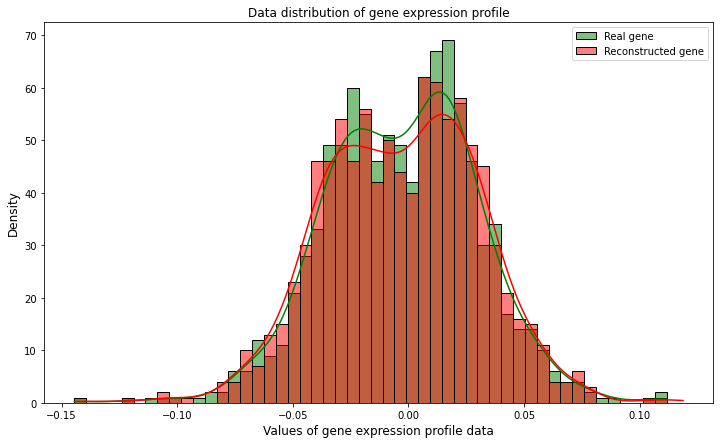

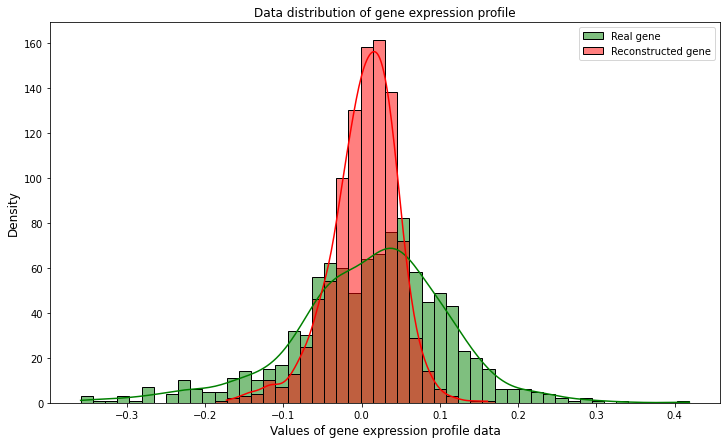

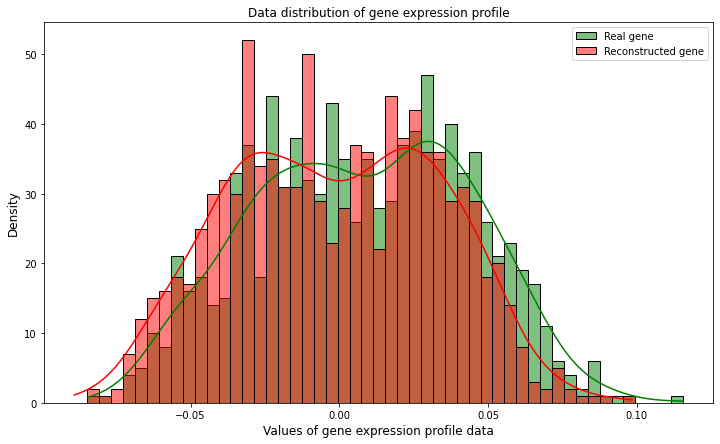

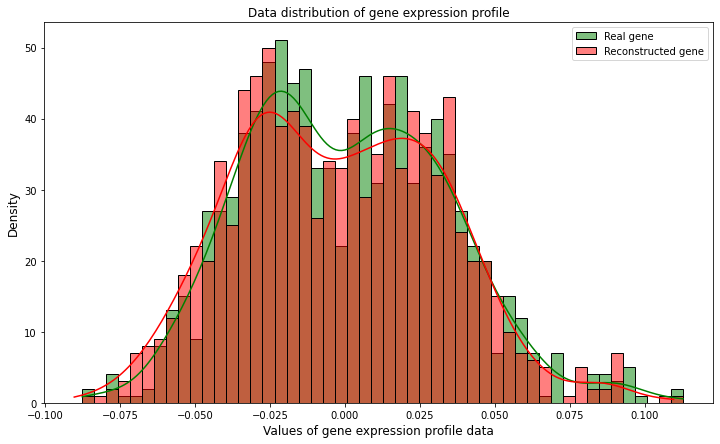

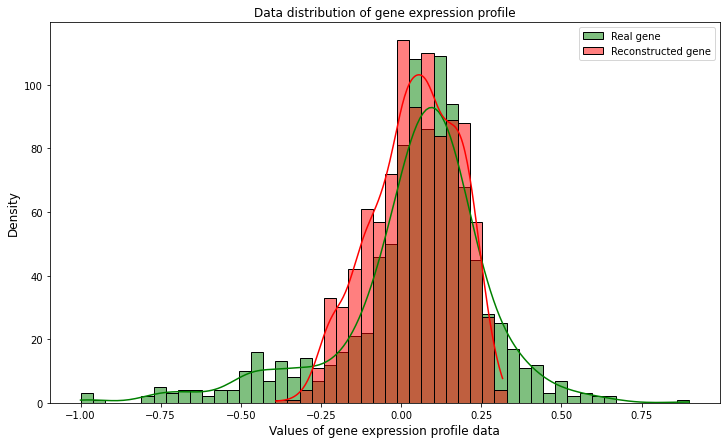

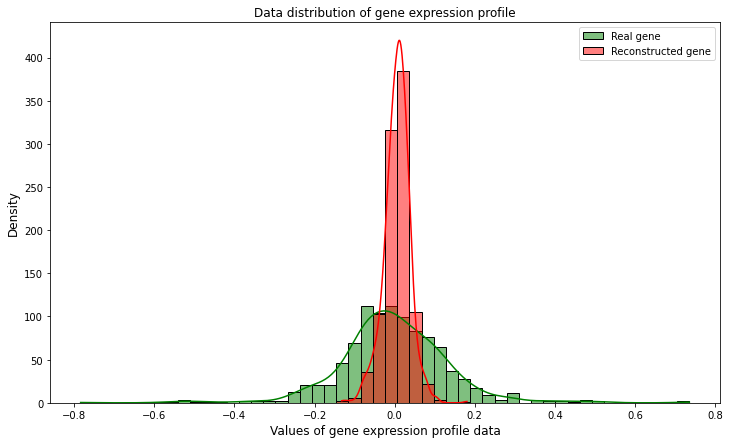

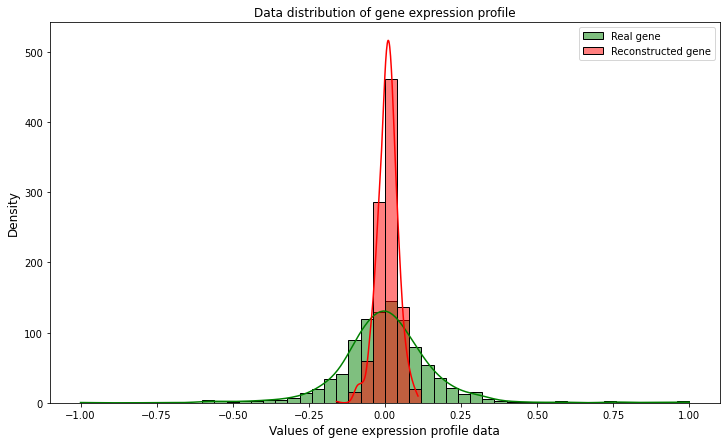

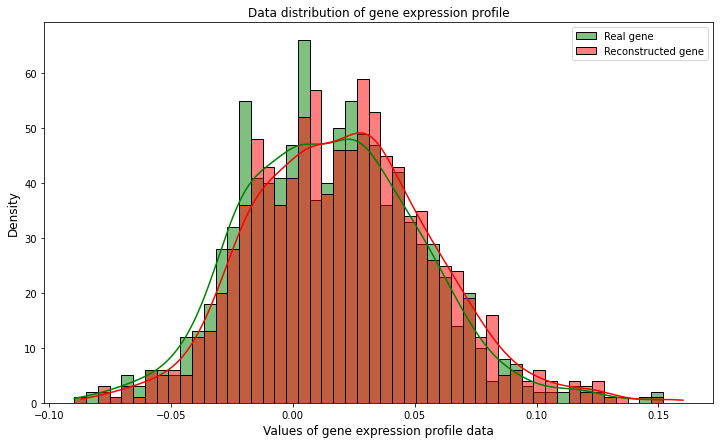

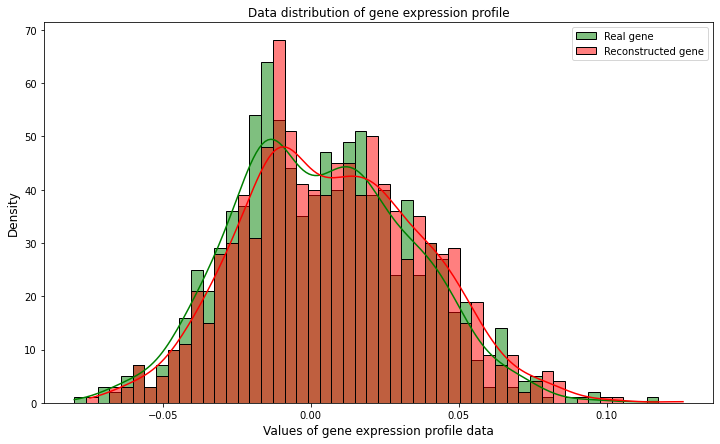

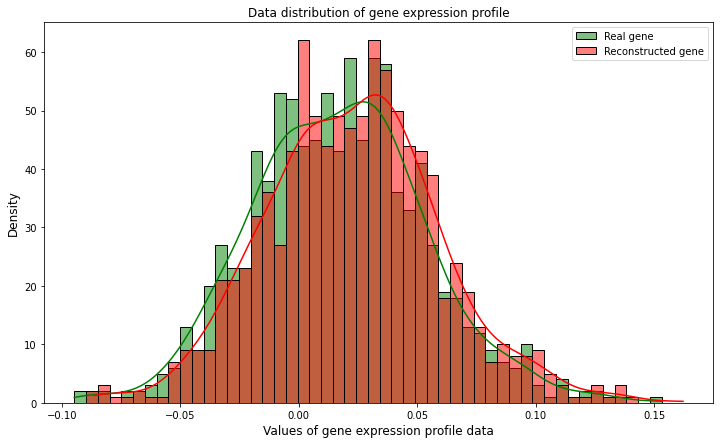

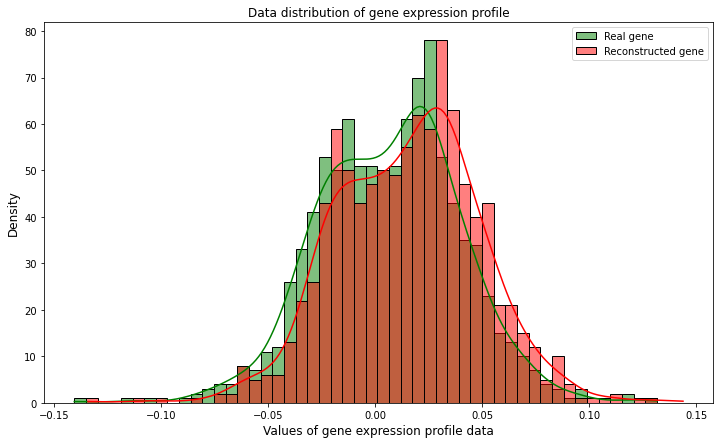

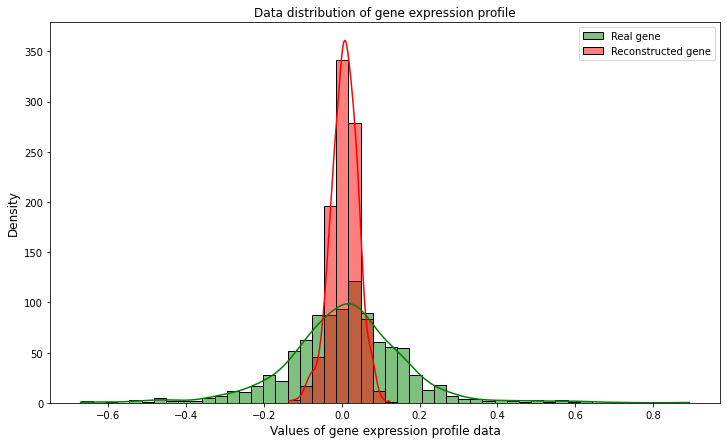

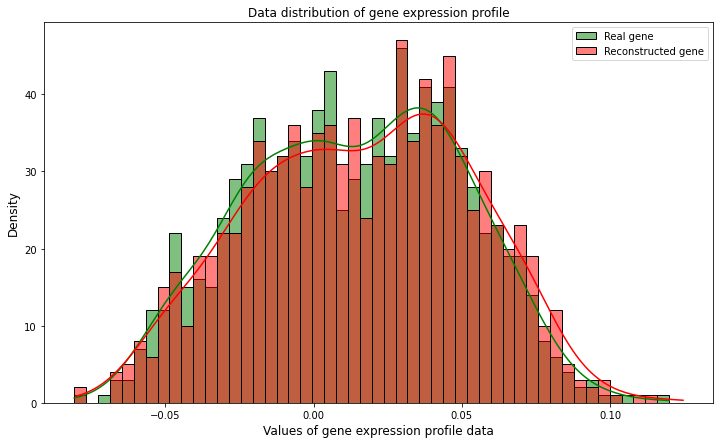

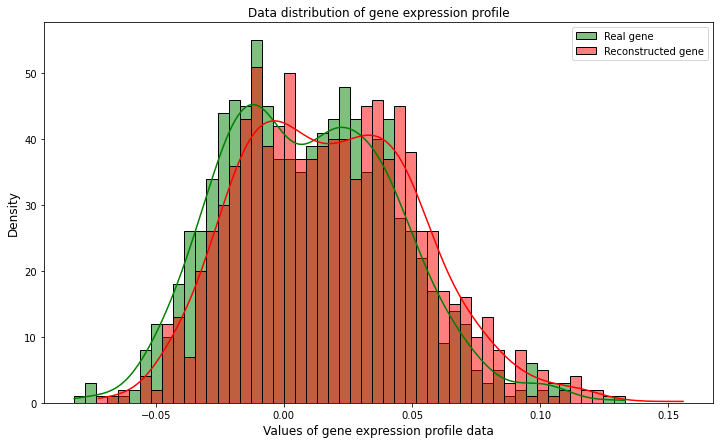

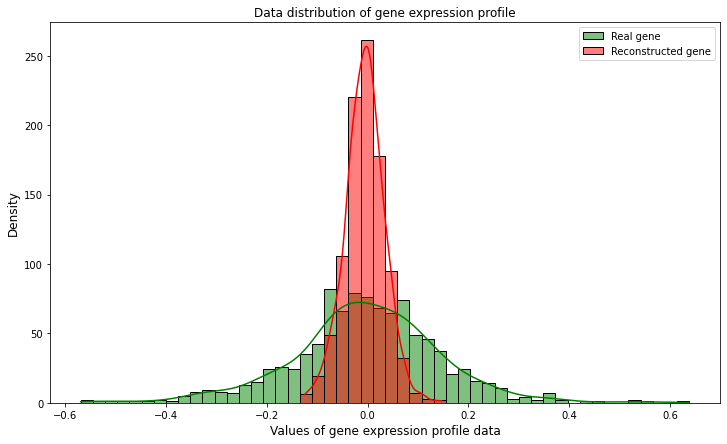

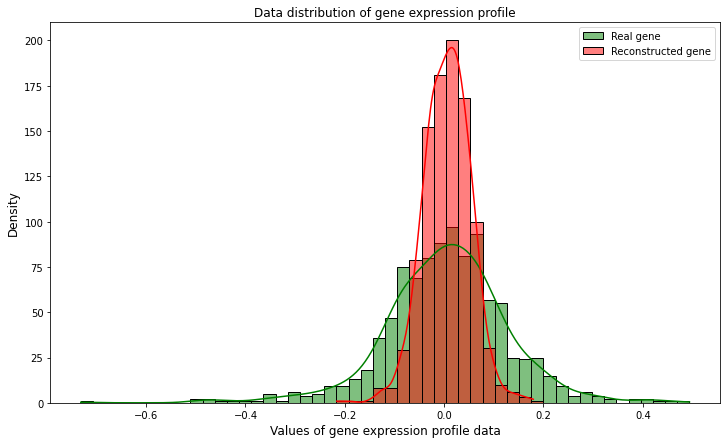

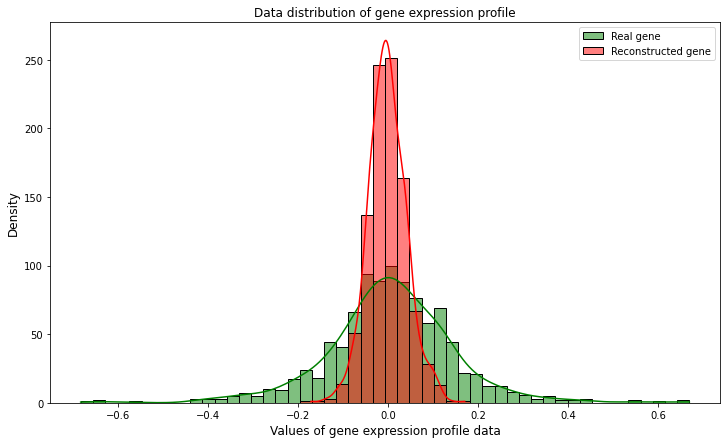

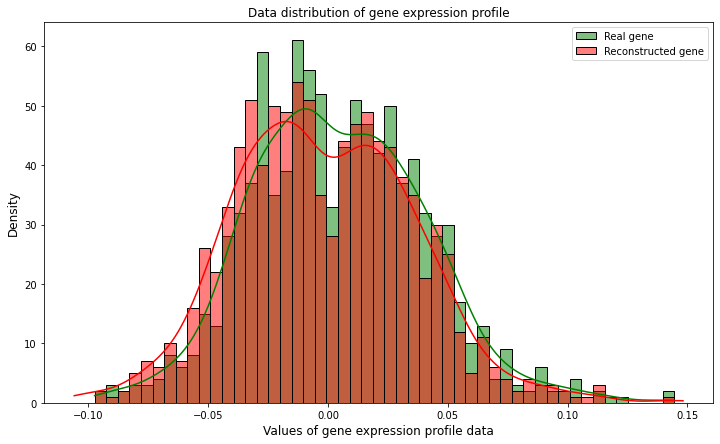

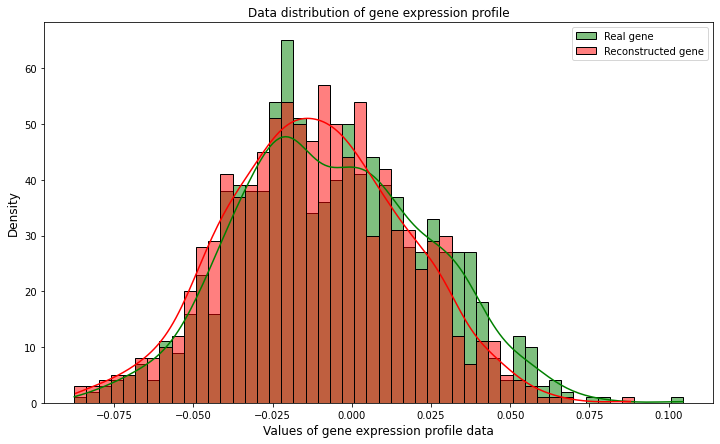

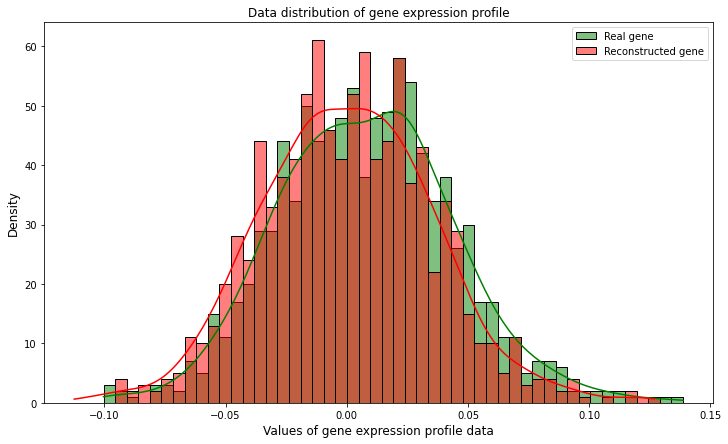

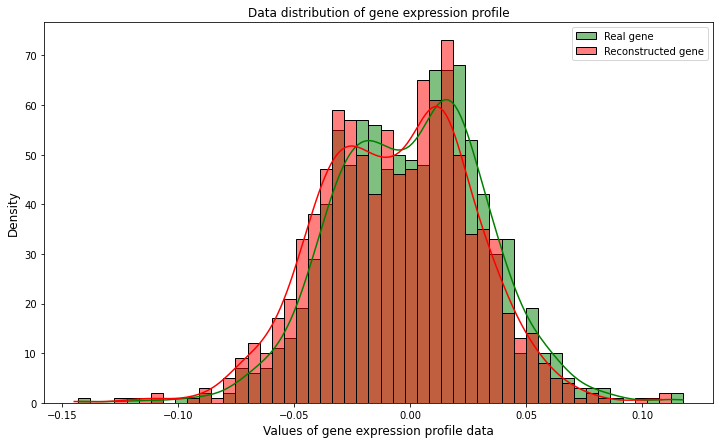

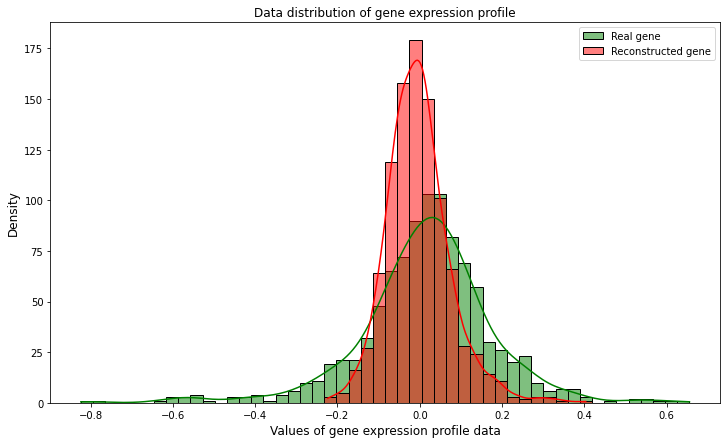

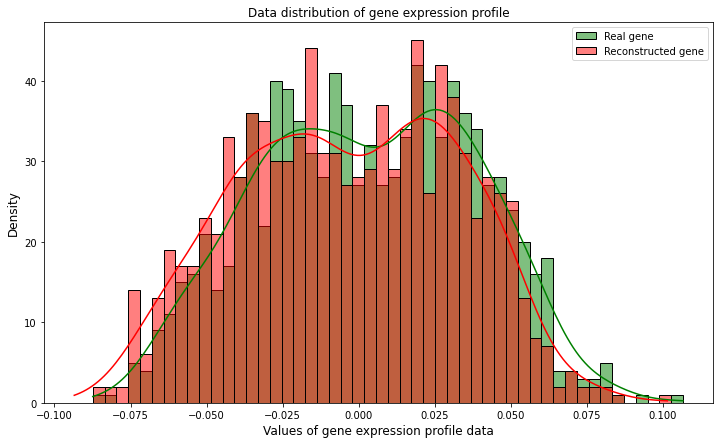

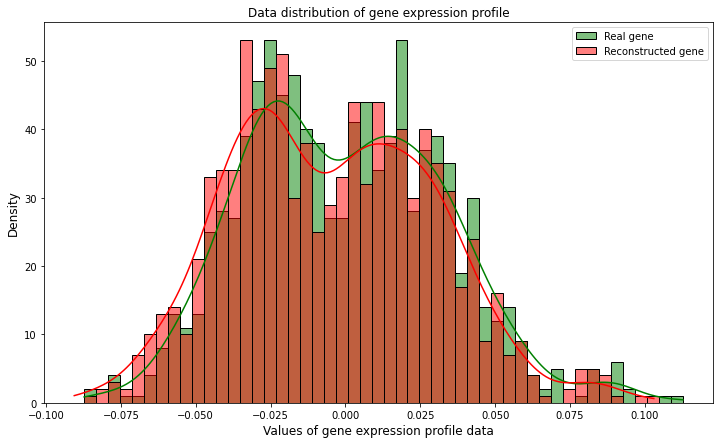

In [21]:
# ====================================================
# Load trained VQ-VAE model
# ====================================================

gene_activation_fn = get_activation_fn(args)

#  Define the trained GeneVAE.  
if args.cell_name != 'AllCellParallel':
    trained_vq_vae = VQ_VAE(
        gene_num=args.gene_num,
        num_emb=args.gene_num_emb,  
        emb_dim=args.gene_emb_dim,   
        com_cost=args.gene_com_cost,
        activation_fn=gene_activation_fn,
        dropout=args.gene_dropout
    ).to(get_device())
    
elif args.cell_name == 'AllCellParallel':
    cell_lines = select_clls_based_on_missing_rates(args)
    trained_vq_vae = VQ_VAE_MultiCells(
        gene_num=args.gene_num,
        num_emb=args.gene_num_emb,  
        emb_dim=args.gene_emb_dim,   
        com_cost=args.gene_com_cost,
        activation_fn=gene_activation_fn,
        dropout=args.gene_dropout,
        num_cell_lines=len(cell_lines)
    ).to(get_device())

# Load the trained GeneVAE
trained_vq_vae.load_model( make_output_directory_path(args) + args.saved_gene_vae + '.pkl') 
print('Load the trained VQ-VAE.')
print(make_output_directory_path(args) + args.saved_gene_vae + '.pkl')

# Test GeneVAE 
if args.cell_name != 'AllCellParallel':
    show_all_gene_densities( args, trained_vq_vae)
elif args.cell_name == 'AllCellParallel':
    show_all_gene_densities_MultiCell( args, trained_vq_vae )
print('Gene expression profile distribution is created.')

In [6]:
gene_activation_fn = get_activation_fn(args)

trained_vq_vae = VQ_VAE(
        gene_num=978,
        num_emb=128,  
        emb_dim=[1000, 512, 256],   
        com_cost=0.25,
        activation_fn=gene_activation_fn,
        dropout=0.1
    ).to(get_device())

i_f = "/Users/nanbasatoko/Documents/target_repositioning4/VAE/data/VQ_VAE/trt_sh.cgs/CellLine_All/Epo500_Lr0.002_Hid1000_512_256_Lat128_Bat64_Comc0.25/saved_vq_vae.pkl"
trained_vq_vae.load_model(i_f )

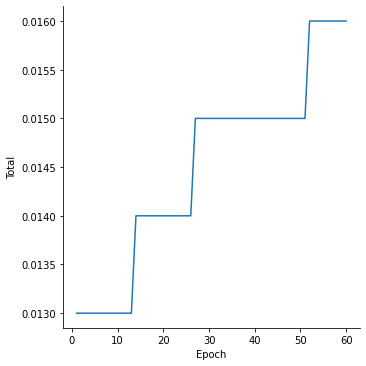

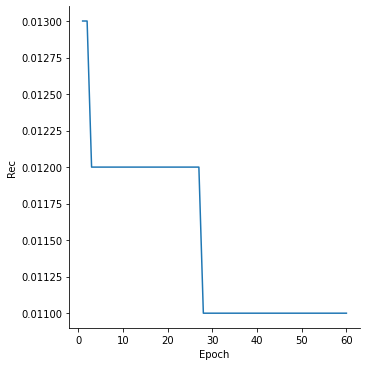

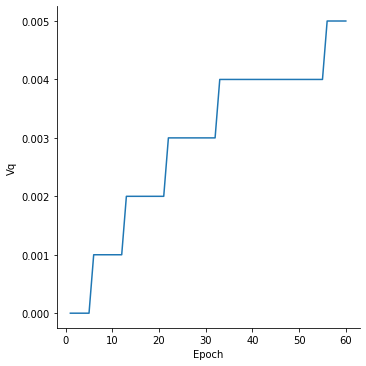

In [22]:
#==================================================================
# Loss distribution.
#==================================================================

loss_df = pd.read_csv(f"{ make_output_directory_path(args) }/{args.gene_vae_train_results}", sep=',')

sns.relplot(x='Epoch', y='Total', data=loss_df, kind='line')
plt.savefig( f"{ make_output_directory_path(args) }/Total_loss.png", dpi=150 )
sns.relplot(x='Epoch', y='Rec', data=loss_df, kind='line')
plt.savefig( f"{ make_output_directory_path(args) }/Rec_loss.png", dpi=150 )
sns.relplot(x='Epoch', y='Vq', data=loss_df, kind='line')
plt.savefig( f"{ make_output_directory_path(args) }/Vq_loss.png", dpi=150 )
# plt.show()

In [23]:
#==================================================================
# Extract features from gene expression profiles
#==================================================================
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
trained_vq_vae.eval()
# train_loader = load_gene_expression_dataset(args) # Note that "Shuffle=True"

# Data loader
if args.cell_name != 'AllCellParallel':
    train_loader = load_gene_expression_dataset(args)
    print("Complete dataload")
    
    for (_, genes) in enumerate(train_loader):
        genes = genes.to(get_device())
        print(genes.shape)

        gene_latent_vectors = trained_vq_vae.encoder(genes).to(get_device()) # [batch_size, gene_latent_size]
        # Operate on a batch of gene expression features
        print(gene_latent_vectors.size())
        print(gene_latent_vectors)
        break
    
    
elif args.cell_name == 'AllCellParallel':
    train_loader, num_cell_lines = load_gene_expression_dataset_MultiCell(args)  
#     dropout_fn = nn.Dropout(p=args.gene_dropout)
    print("Complete dataload")
    
    for (_, genes) in enumerate(train_loader):
        genes = genes.to(get_device())
        print(genes.shape)
        
        # Each cell line encoders.
        each_cell_out = []
        for idx, enc in enumerate(trained_vq_vae.each_cell_encoder):
            each_cell_out.append(enc(genes[:,idx]))
        each_cell_out = torch.cat(each_cell_out, dim=1).to(get_device()) # [batch_size, gene_latent_size]
        gene_latent_vectors = trained_vq_vae.integrated_encoder(each_cell_out)
        # Operate on a batch of gene expression features
        print(gene_latent_vectors.size())
        print(gene_latent_vectors)
        break

#         # Each cell line encoders.
#         each_cell_out = []
#         for idx, enc in enumerate(trained_vq_vae.each_cell_encoder):
#             out = enc(genes[:,idx])
#             out = gene_activation_fn(out)
#             out = dropout_fn(out)
#             each_cell_out.append(out)
#         each_cell_out = torch.cat(each_cell_out, dim=1).to(get_device()) # [batch_size, gene_latent_size]
#         gene_latent_vectors = trained_vq_vae.integrated_encoder(each_cell_out)
#         # Operate on a batch of gene expression features
#         print(gene_latent_vectors.size())
#         print(gene_latent_vectors)
#         break


Selected cell lines: 10
Complete dataload
torch.Size([64, 10, 978])
torch.Size([64, 256])
tensor([[ 0.0814, -0.0132,  0.0901,  ...,  0.0032,  0.0274, -0.0056],
        [ 0.0532, -0.0010,  0.0124,  ...,  0.1075, -0.0787, -0.0419],
        [-0.0306,  0.0617, -0.0149,  ..., -0.0457,  0.1170, -0.1017],
        ...,
        [-0.0602, -0.1129, -0.0312,  ..., -0.0421, -0.1277,  0.0920],
        [ 0.0617,  0.0097,  0.0461,  ...,  0.0507, -0.0164, -0.0334],
        [ 0.3890,  0.1555,  0.0080,  ...,  0.1154,  0.0535,  0.1700]],
       grad_fn=<LeakyReluBackward0>)


In [7]:
# ========================================================
# Original gene expression signatures for each cell line
# ========================================================

"""
選択した細胞の情報のみ使う場合
"""

if args.cell_name != 'AllCellParallel':

    gene_data = pd.read_csv(args.gene_expression_file + args.pert_type + '.txt', sep='\t')

    # ----- Mean target signatures across cell lines ----- #
    if args.cell_name == "All":
        gene_data = gene_data.drop('cell_mfc_name', axis = 1
                                  ).groupby(by = 'cmap_name').mean().reset_index() # Average values for each protein
    elif args.cell_name == "AllCell":
        gene_data = gene_data.drop('cell_mfc_name', axis = 1) # Use all cell lines' signatures
    else:
        gene_data = gene_data[ gene_data['cell_mfc_name'] == args.cell_name ].drop('cell_mfc_name', axis = 1) # Select cell line.

    gene_data = gene_data.set_index( 'cmap_name' ) # Set index.


    # ------ Normalize data per gene ------ #
    if args.gene_scaling == 'Orig':
        gene_data = gene_data # Original data
    elif args.gene_scaling == 'Std': 
        gene_data = (gene_data - gene_data.mean())/gene_data.std()
    elif args.gene_scaling == 'Cent': 
        gene_data = (gene_data - gene_data.mean())
    elif args.gene_scaling == 'MaxAbs':
        transformer = MaxAbsScaler() # Define transformer.
        X_scaled = transformer.fit_transform(gene_data) # MaxAbsScaler
        X_scaled = pd.DataFrame(X_scaled, index=gene_data.index, columns=gene_data.columns) # Numpy -> Pandas
        gene_data = X_scaled.replace(0, np.nan
                                ).dropna(how = 'all', axis = 1).fillna(0) # Remove genes with 0 values for all samples
        del X_scaled

    all_gene_list = sorted(set(gene_data.index)) # All gene list

    print('Gene data: ', gene_data.shape)
    print(gene_data)


In [10]:
gene_data = pd.read_csv(args.gene_expression_file + args.pert_type + '.txt', sep='\t')

# ----- Mean target signatures across cell lines ----- #
# if args.cell_name == "All":
gene_data = gene_data.drop('cell_mfc_name', axis = 1
                          ).groupby(by = 'cmap_name').mean().reset_index() # Average values for each protein
# elif args.cell_name == "AllCell":
#     gene_data = gene_data.drop('cell_mfc_name', axis = 1) # Use all cell lines' signatures
# else:
#     gene_data = gene_data[ gene_data['cell_mfc_name'] == args.cell_name ].drop('cell_mfc_name', axis = 1) # Select cell line.

gene_data = gene_data.set_index( 'cmap_name' ) # Set index.


# # ------ Normalize data per gene ------ #
# if args.gene_scaling == 'Orig':
#     gene_data = gene_data # Original data
# elif args.gene_scaling == 'Std': 
#     gene_data = (gene_data - gene_data.mean())/gene_data.std()
# elif args.gene_scaling == 'Cent': 
#     gene_data = (gene_data - gene_data.mean())
# elif args.gene_scaling == 'MaxAbs':
#     transformer = MaxAbsScaler() # Define transformer.
#     X_scaled = transformer.fit_transform(gene_data) # MaxAbsScaler
#     X_scaled = pd.DataFrame(X_scaled, index=gene_data.index, columns=gene_data.columns) # Numpy -> Pandas
#     gene_data = X_scaled.replace(0, np.nan
#                             ).dropna(how = 'all', axis = 1).fillna(0) # Remove genes with 0 values for all samples
#     del X_scaled

all_gene_list = sorted(set(gene_data.index)) # All gene list

print('Gene data: ', gene_data.shape)
print(gene_data)

Gene data:  (4345, 978)
             hsa:16    hsa:23    hsa:25    hsa:30    hsa:39    hsa:47  \
cmap_name                                                               
61E3.4    -0.787099 -0.692046 -0.703766 -0.508508 -0.881862 -0.645612   
A2M       -0.392859 -0.957679 -0.539289 -0.374008 -0.995647 -0.428892   
AAK1      -0.801514 -0.703662 -0.763023 -0.522704 -0.851478 -0.695458   
AARS      -2.022966 -1.021414 -0.432949 -0.517287 -0.744842 -0.491829   
AATF      -0.644072 -0.752731 -0.890779 -0.579371 -0.820027 -0.411769   
...             ...       ...       ...       ...       ...       ...   
ZSCAN1    -0.824859 -0.599566 -0.878491 -0.373903 -0.728534 -0.630204   
ZSCAN29   -0.669250 -0.570149 -0.644156 -0.509254 -0.773948 -0.576248   
ZSCAN4    -0.638553 -0.890059 -0.648912 -0.434647 -0.730948 -0.731264   
ZSWIM2    -0.919952 -0.896670 -0.530252 -0.374412 -1.049383 -0.345306   
ZW10      -0.794815 -0.647100 -0.866319 -0.605329 -0.538281 -0.724266   

            hsa:102   hsa:

In [11]:
# Tensor data type <- pandas 
gene_data_tensor = gene_data.values.astype('float32') # Pandas -> numpy
gene_data_tensor = torch.tensor( gene_data_tensor ).float()
print("Size of the original gene expression signatures: {}".format(gene_data_tensor.shape) )

# Fix seed values for reproducibility.
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Extract latent vectors of gene exppression signatures.
trained_vq_vae.eval() # 推論モードに切り替える
feature_data = trained_vq_vae.encoder( gene_data_tensor ).to(get_device()) # Extract latent and output features (0: latent features, 1: output features)
feature_data = feature_data.to(get_device()).detach().numpy().copy() # tensor -> numpy array
feature_data = pd.DataFrame( feature_data, index=gene_data.index )
# feature_data.to_csv( make_output_directory_path(args) + 'latent_vectors.txt', sep = '\t')

print("Size of the embedded gene expression signatures: {}".format(feature_data.shape))

print(feature_data)

Size of the original gene expression signatures: torch.Size([4345, 978])
Size of the embedded gene expression signatures: (4345, 256)
                  0           1           2         3           4    \
cmap_name                                                             
61E3.4     308.686493 -170.615692  214.472473 -0.395839  255.517044   
A2M        288.635010 -159.459625  200.463928 -0.369382  238.788422   
AAK1       321.038391 -177.441788  223.044540 -0.412036  265.741333   
AARS       302.700378 -167.263306  210.265289 -0.387857  250.459641   
AATF       298.711853 -165.131378  207.598724 -0.382895  247.344910   
...               ...         ...         ...       ...         ...   
ZSCAN1     306.417969 -169.381500  212.937378 -0.392822  253.688644   
ZSCAN29    298.723328 -165.106598  207.564209 -0.382559  247.231537   
ZSCAN4     307.376892 -169.878784  213.549911 -0.394186  254.403046   
ZSWIM2     307.731812 -169.999649  213.709137 -0.394423  254.601700   
ZW10       309

In [25]:
# ========================================================
# Extract feature vectors for each cell line
# ========================================================

"""
選択した細胞の情報のみ使う場合
"""

if args.cell_name != 'AllCellParallel':

    # Tensor data type <- pandas 
    gene_data_tensor = gene_data.values.astype('float32') # Pandas -> numpy
    gene_data_tensor = torch.tensor( gene_data_tensor ).float()
    print("Size of the original gene expression signatures: {}".format(gene_data_tensor.shape) )

    # Fix seed values for reproducibility.
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

    # Extract latent vectors of gene exppression signatures.
    trained_vq_vae.eval() # 推論モードに切り替える
    feature_data = trained_vq_vae.encoder( gene_data_tensor ).to(get_device()) # Extract latent and output features (0: latent features, 1: output features)
    feature_data = feature_data.to(get_device()).detach().numpy().copy() # tensor -> numpy array
    feature_data = pd.DataFrame( feature_data, index=gene_data.index )
    feature_data.to_csv( make_output_directory_path(args) + 'latent_vectors.txt', sep = '\t')

    print("Size of the embedded gene expression signatures: {}".format(feature_data.shape))

    print(feature_data)

In [5]:
# ========================================================
# Original gene expression signatures for all cell lines
# ========================================================

"""
全細胞の情報を並列に計算する場合
"""

if args.cell_name == 'AllCellParallel':

    # ===== Load gene expression data ===== #
    gene_data = pd.read_csv(args.gene_expression_file + args.pert_type + '.txt', sep='\t')
    all_gene_list = sorted(set(gene_data['cmap_name'])) # All gene list


    # ===== Missing rate data ====== #
    i_f = "../../../target_repositioning2/multitask/data/LINCS/cell_kdoe_list.txt"
    miss_df = pd.read_csv( i_f, sep ='\t', encoding='shift-jis' )

    if args.pert_type == 'trt_sh.cgs':
        col_name = 'kd_missing'
    elif args.pert_type == 'trt_oe':
        col_name = 'oe_missing'

    # Select cell lines based on missing rate.
    miss_df = miss_df.dropna(subset=col_name) # Select overexpression signature's cells
    miss_df = miss_df[miss_df[col_name] >= args.cell_missing_rate ] # Select cell lines based on missing rate
    cell_lines = sorted(set(miss_df['cell'])) # Cell line list.
    print("Selected cell lines: {}".format(len(cell_lines)) )


    # ===== Normalize for each cell line ====== #
    processed_gene_data = pd.DataFrame()
    for cell in cell_lines:

        # ----- Select cell line. ------ #
        cell_gene_data = gene_data[gene_data['cell_mfc_name'] == cell ].drop('cell_mfc_name', axis = 1) # Select cell line.
        cell_gene_data = cell_gene_data.set_index( 'cmap_name' ) # Set index.
        cell_gene_data = cell_gene_data.loc[all_gene_list] # 全細胞でタンパクの並び順を揃える

        # ------ Normalize data per gene ------ #
        if args.gene_scaling == 'Orig':
            cell_gene_data = cell_gene_data # Original data
        elif args.gene_scaling == 'Std': 
            cell_gene_data = (cell_gene_data - cell_gene_data.mean())/cell_gene_data.std()
        elif args.gene_scaling == 'Cent': 
            cell_gene_data = (cell_gene_data - cell_gene_data.mean())
        elif args.gene_scaling == 'MaxAbs':
            transformer = MaxAbsScaler() # Define transformer.
            X_scaled = transformer.fit_transform(cell_gene_data) # MaxAbsScaler
            X_scaled = pd.DataFrame(X_scaled, index=cell_gene_data.index, columns=cell_gene_data.columns) # Numpy -> Pandas
            cell_gene_data = X_scaled.replace(0, np.nan
                                    ).dropna(how = 'all', axis = 1).fillna(0) # Remove genes with 0 values for all samples
            del X_scaled

        cell_gene_data.insert(0, 'cell_mfc_name', cell) # cell name
        cell_gene_data = cell_gene_data.reset_index() # reset index
        processed_gene_data = pd.concat([processed_gene_data, cell_gene_data], axis = 0)


    # ===== 各タンパク質いついて、全細胞の情報をマージしたnumpy arrayを作成する ===== #

    processed_gene_array = []

    for protein in all_gene_list:

        cell_inputs = processed_gene_data[processed_gene_data['cmap_name'] == protein] # Select protein rows (cell lines x 978 genes).
        cell_inputs = cell_inputs.sort_values(by = 'cell_mfc_name') # Sort cell line names.
        cell_inputs = cell_inputs.drop(['cmap_name', 'cell_mfc_name'], axis = 1 ) # Drop columns.
        processed_gene_array = processed_gene_array + [cell_inputs.values] # Add input data

    else:
        processed_gene_array = np.array(processed_gene_array).astype('float32') # list => numpy array

    print(processed_gene_array.shape)

Selected cell lines: 10
(4040, 10, 978)


In [6]:
all_gene_list

['(AC074117.10)',
 '(AC074117.10_MUT)',
 '(AC084809.2)',
 '(AC098617.1)',
 '(AC115618.1)',
 '(AK097618)',
 '(AL110181)',
 '(AL110181_MUT)',
 '(ASNSD1)',
 '(AX746851)',
 '(AX747325)',
 '(B3GNT5)',
 '(CBR3-AS1)',
 '(CD27-AS1)',
 '(CHST2)',
 '(CITF22-92A6.1)',
 '(CTA-292E10.6)',
 '(CTC-480C2.1)',
 '(CTD-2270L9.4)',
 '(CTD-3131K8.2)',
 '(DDIT3)',
 '(DLG5-AS1)',
 '(EIF1B)',
 '(EMC3-AS1)',
 '(EMX2OS)',
 '(ENTPD1-AS1)',
 '(ERVK3-1)',
 '(FAM220A)',
 '(FAM83H-AS1)',
 '(FAM83H-AS1_MUT)',
 '(FOXD3-AS1)',
 '(FOXD3-AS1_MUT)',
 '(G008259)',
 '(G032161)',
 '(G036240)',
 '(G047227)',
 '(G048207)',
 '(G054633)',
 '(G063514)',
 '(G070104)',
 '(G083755)',
 '(G085301)',
 '(HLA-F-AS1)',
 '(LINC00240)',
 '(LINC00667)',
 '(LINC00842)',
 '(LINC01004)',
 '(LINC01184)',
 '(LINC01399)',
 '(LINC01589)',
 '(LINC01589_MUT)',
 '(LINC02081.2)',
 '(LIPE-AS1)',
 '(LOC100130987)',
 '(LOC100505549)',
 '(LOC100506302)',
 '(LOC101927497)',
 '(LOC101927989)',
 '(LOC102724434)',
 '(LOC105372440)',
 '(LOC284241)',
 '(LOC40055

In [27]:
# ====== Extract feature vectors ====== #

if args.cell_name == 'AllCellParallel':
    # Tensor data type <- pandas 
    # gene_data_tensor = gene_data.values.astype('float32') # Pandas -> numpy
    gene_data_tensor = torch.tensor( processed_gene_array ).float()
    print("Size of the original gene expression signatures: {}".format(gene_data_tensor.shape) )

    # Fix seed values for reproducibility.
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)

    # Extract latent vectors of gene exppression signatures.
    trained_vq_vae.eval() # 推論モードに切り替える
    dropout_fn = nn.Dropout(p=args.gene_dropout)

    # Each cell line encoders.
    each_cell_out = []
    for idx, enc in enumerate(trained_vq_vae.each_cell_encoder):
        each_cell_out.append(enc(gene_data_tensor[:,idx]))
    #     out = enc(gene_data_tensor[:,idx])
    #     out = gene_activation_fn(out)
    #     out = dropout_fn(out)
    #     each_cell_out.append(out)
    each_cell_out = torch.cat(each_cell_out, dim=1).to(get_device()) # [batch_size, gene_latent_size]
    feature_data = trained_vq_vae.integrated_encoder(each_cell_out) # Extract latent and output features (0: latent features, 1: output features)
    feature_data = feature_data.to(get_device()).detach().numpy().copy() # tensor -> numpy array
    feature_data = pd.DataFrame( feature_data, index=all_gene_list )
    feature_data.to_csv( make_output_directory_path(args) + 'latent_vectors.txt', sep = '\t')

    print("Size of the embedded gene expression signatures: {}".format(feature_data.shape))

    print(feature_data)

Size of the original gene expression signatures: torch.Size([4040, 10, 978])
Size of the embedded gene expression signatures: (4040, 256)


0         1         2         3         4         5    \
(AC074117.10)      0.081316  0.033857 -0.030774  0.009637 -0.010633 -0.013956   
(AC074117.10_MUT)  0.169088  0.035713  0.076216  0.146013 -0.054749 -0.191238   
(AC084809.2)       0.145618 -0.016258  0.050056  0.111062 -0.063352 -0.153798   
(AC098617.1)      -0.041705 -0.032315 -0.016769 -0.065811 -0.064977 -0.052935   
(AC115618.1)       0.019172 -0.005810 -0.028427 -0.010583  0.016042  0.016034   
...                     ...       ...       ...       ...       ...       ...   
ZSCAN5A           -0.021946 -0.030075 -0.000483 -0.020295 -0.036087 -0.018068   
ZSWIM2            -0.093994 -0.005309 -0.072145 -0.141396 -0.102460 -0.051611   
ZUFSP              0.055100 -0.023654  0.032893 -0.007142  0.117775  0.047048   
ZXDC              -0.001074 -0.043192  0.013271 -0.004372 -0.011029 -0.017343   
ZZZ3               0.076878  0.023514  0.025394 -0.013415  0.070166  0.069277   

                        6         7         8         9    ...       246  \
(AC074117.10)      0.041081  0.007926  0.078985 -0.059457  ...  0.016469   
(AC074117.10_MUT) -0.015655 -0.114376  0.239693  0.058239  ...  0.027944   
(AC084809.2)      -0.022810 -0.126025  0.146172  0.056195  ...  0.066591   
(AC098617.1)       0.005620 -0.047812 -0.012014  0.040366  ... -0.018395   
(AC115618.1)       0.053446 -0.020520 -0.048020 -0.010891  ...  0.034696   
...                     ...       ...       ...       ...  ...       ...   
ZSCAN5A           -0.043697  0.009179 -0.045301 -0.051331  ...  0.031031   
ZSWIM2            -0.075286  0.112175 -0.166603  0.123218  ...  0.112276   
ZUFSP              0.012399 -0.009134  0.014415  0.007504  ... -0.054048   
ZXDC              -0.032981  0.008512 -0.022634 -0.050208  ...  0.033100   
ZZZ3               0.043441 -0.027465  0.117744  0.067167  ... -0.061352   

                        247       248       249       250       251       252  \
(AC074117.10)      0.046896 -0.002316 -0.027150 -0.007523 -0.014293  0.030491   
(AC074117.10_MUT) -0.000069 -0.124863 -0.030744 -0.108399  0.058419 -0.025201   
(AC084809.2)      -0.016138 -0.074675  0.017445 -0.090175  0.050488 -0.031361   
(AC098617.1)       0.097163  0.107882  0.044504 -0.055199  0.099875 -0.016475   
(AC115618.1)      -0.048328  0.003156  0.018579  0.007534 -0.021827 -0.022366   
...                     ...       ...       ...       ...       ...       ...   
ZSCAN5A           -0.018416 -0.017598 -0.024349 -0.030463  0.026677 -0.019277   
ZSWIM2            -0.124430  0.088180 -0.010492  0.058684  0.126427  0.161435   
ZUFSP             -0.000086 -0.016586  0.086055 -0.008467 -0.041052  0.081307   
ZXDC              -0.008810 -0.018334 -0.018546 -0.012370  0.014666  0.003250   
ZZZ3               0.056832  0.021008  0.059630  0.004866 -0.062836  0.074537   

                        253       254       255  
(AC074117.10)      0.025136 -0.052689 -0.024396  
(AC074117.10_MUT)  0.130507  0.060820  0.049693  
(AC084809.2)       0.069779 -0.008356  0.009490  
(AC098617.1)       0.003781 -0.052205  0.086059  
(AC115618.1)      -0.044295 -0.061007 -0.019090  
...                     ...       ...       ...  
ZSCAN5A           -0.040408  0.010741  0.067259  
ZSWIM2            -0.104747 -0.133966  0.065151  
ZUFSP              0.109230 -0.044930 -0.031909  
ZXDC               0.001606  0.026670  0.031804  
ZZZ3               0.112653 -0.054853 -0.073410  

[4040 rows x 256 columns]

In [10]:
# #==================================================================
# # Read the data, which contains smiles, inchikey, and gene values
# #==================================================================

# gene_data = pd.read_csv(args.gene_expression_file + args.pert_type + '.txt', sep='\t')

# # ------ Mean target signatures across cell lines. ------ #
# if args.cell_name == "All":
#     gene_data = gene_data.drop('cell_mfc_name', axis = 1
#                               ).groupby(by = 'cmap_name').mean().reset_index() # Average values for each protein
# elif args.cell_name == "AllCell":
#     gene_data = gene_data.drop('cell_mfc_name', axis = 1) # Use all cell lines' signatures
# else:
#     gene_data = gene_data[ gene_data['cell_mfc_name'] == args.cell_name ].drop('cell_mfc_name', axis = 1) # Select cell line.
    
# gene_data = gene_data.set_index( 'cmap_name' ) # Set index.


# # ------ Normalize data per gene ------ #
# if GENE_SCALING == 'Orig':
#     gene_data = gene_data # Original data
# elif GENE_SCALING == 'Std': 
#     gene_data = (gene_data - gene_data.mean())/gene_data.std()
# elif GENE_SCALING == 'Cent': 
#     gene_data = (gene_data - gene_data.mean())
# elif GENE_SCALING == 'MaxAbs':
#     transformer = MaxAbsScaler() # Define transformer.
#     X_scaled = transformer.fit_transform(gene_data) # MaxAbsScaler
#     X_scaled = pd.DataFrame(X_scaled, index=gene_data.index, columns=gene_data.columns) # Numpy -> Pandas
#     gene_data = X_scaled.replace(0, np.nan
#                             ).dropna(how = 'all', axis = 1).fillna(0) # Remove genes with 0 values for all samples
#     del X_scaled
    
    
# gene_data_index = list(gene_data.index)

# gene_data = gene_data.values.astype('float32') # Pandas -> numpy
    

# print('Gene data: ', gene_data.shape)
# gene_data

Gene data:  (73865, 978)


hsa:16    hsa:23   hsa:25    hsa:30   hsa:39    hsa:47   hsa:102  \
cmap_name                                                                       
SLC16A5   -0.168430 -0.459540 -0.60300  0.122940 -0.88953 -0.818730  0.585070   
POLRMT     0.663770 -0.596500 -0.86644  0.545040 -0.24683 -0.437990  0.000125   
SUOX       0.266140  0.954070 -0.80617 -0.181430  0.73943  0.637240  0.122520   
MED4       0.365040  0.945850 -1.58150  0.566890 -0.17123  1.076300  1.203300   
HLA-DRB3  -0.155260 -0.063949 -0.27029  0.176000 -0.16888 -0.027124  0.054392   
...             ...       ...      ...       ...      ...       ...       ...   
RTN2      -0.020108  0.012442  0.23032  0.201780 -0.21003  0.014571  0.175400   
KDM4C     -0.167790 -0.496100 -0.16120  0.025213  0.46639  0.087836 -0.559050   
PHF19      0.629480 -0.300720  1.73590  0.405660 -1.23750  0.466200  0.784560   
ABCC3     -0.460580 -0.164100  0.14190  0.684470 -0.42912 -0.371330 -0.535870   
IGF1R      0.468400 -0.419530  0.26789  0.343180 -0.61408 -0.698630 -0.901510   

            hsa:128  hsa:142  hsa:154  ...  hsa:94239  hsa:116832  hsa:124583  \
cmap_name                              ...                                      
SLC16A5    0.046723  0.67761  0.21581  ...  -0.534720   -0.166690     0.49485   
POLRMT     0.015384  0.97840 -0.37653  ...  -0.127890   -0.200120     0.54118   
SUOX       0.420180  0.26236 -0.93148  ...  -0.066080   -0.151730    -0.18220   
MED4       0.271070 -1.30870  0.83198  ...   0.243880    0.289730    -0.77872   
HLA-DRB3  -0.187020 -0.22016  0.36618  ...   0.202310    0.297280    -0.43777   
...             ...      ...      ...  ...        ...         ...         ...   
RTN2      -0.268420 -0.17431  0.53433  ...   0.060584    0.283610    -0.16737   
KDM4C     -0.964830 -1.35260 -0.14601  ...   0.599310    0.527000    -0.58661   
PHF19     -2.866600  0.99711 -0.27063  ...  -0.200920   -0.051895     0.32531   
ABCC3      0.529250  0.22292  1.70250  ...   0.919060    2.282900    -0.15646   
IGF1R     -0.942340 -0.40018  0.29213  ...   0.305530   -0.013805    -0.41388   

           hsa:147179  hsa:148022  hsa:200081  hsa:200734  hsa:256364  \
cmap_name                                                               
SLC16A5     -0.950070    0.214690   -0.556440   -0.193470    0.612420   
POLRMT      -0.499200   -0.814610    0.339600   -0.730660   -0.105920   
SUOX        -0.642840   -0.044581   -1.572900   -0.123440   -0.272430   
MED4         0.049369   -0.124800   -0.054428   -0.253140    1.176800   
HLA-DRB3    -0.144480    0.101570   -0.361480   -0.035124    0.194510   
...               ...         ...         ...         ...         ...   
RTN2         0.056473    0.160200   -0.096232   -0.229480    0.071805   
KDM4C       -0.313640    0.767170   -1.159100    1.766500   -0.611820   
PHF19       -0.345750    0.814630    0.932860   -0.081782    0.563120   
ABCC3       -0.464030   -1.097400    0.218940   -0.031071   -0.697430   
IGF1R       -0.392440   -0.146120   -0.713390    0.122010    0.287800   

           hsa:375346  hsa:388650  
cmap_name                          
SLC16A5     -0.159260   -0.146570  
POLRMT      -0.027765   -0.421920  
SUOX         0.684830    0.590120  
MED4         0.158560    0.222590  
HLA-DRB3     0.204380   -0.089872  
...               ...         ...  
RTN2         0.373970    0.001202  
KDM4C        0.776070    0.844510  
PHF19       -0.549070   -0.574450  
ABCC3        0.499150    0.489480  
IGF1R        0.310560    0.401410  

[73865 rows x 978 columns]

In [11]:
# # ====== Extract feature vectors ====== #

# # Tensor data type <- pandas 
# # gene_data_tensor = gene_data.values.astype('float32') # Pandas -> numpy
# gene_data_tensor = torch.tensor( gene_data_tensor ).float()
# print("Size of the original gene expression signatures: {}".format(gene_data_tensor.shape) )

# # Fix seed values for reproducibility.
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
# torch.cuda.manual_seed(0)

# # Extract latent vectors of gene exppression signatures.
# trained_vq_vae.eval() # 推論モードに切り替える
# feature_data = trained_vq_vae.encoder( gene_data_tensor ).to(get_device()) # Extract latent and output features (0: latent features, 1: output features)
# feature_data = feature_data.to(get_device()).detach().numpy().copy() # tensor -> numpy array
# feature_data = pd.DataFrame( feature_data, index=gene_data.index )
# feature_data.to_csv( make_output_directory_path(args) + 'latent_vectors.txt', sep = '\t')

# print("Size of the embedded gene expression signatures: {}".format(feature_data.shape))

# feature_data

Size of the original gene expression signatures: torch.Size([73865, 978])
Size of the embedded gene expression signatures: (73865, 256)


0         1         2         3         4         5         6    \
cmap_name                                                                    
SLC16A5   -1.0 -1.000000 -0.997298  1.000000  0.376605 -1.000000 -0.998260   
POLRMT    -1.0 -0.999995 -0.999895  0.999997 -0.999634 -1.000000 -0.999929   
SUOX      -1.0 -0.999975 -0.146490  0.999993  0.998955 -0.999985 -0.134388   
MED4      -1.0 -0.999991 -0.391566  0.999997  0.999077 -0.999998 -0.289136   
HLA-DRB3  -1.0 -0.999991 -0.392213  0.999997  0.999084 -0.999998 -0.280444   
...        ...       ...       ...       ...       ...       ...       ...   
RTN2      -1.0 -0.999993 -0.394950  0.999998  0.998990 -0.999998 -0.281271   
KDM4C     -1.0 -0.999986 -0.302268  0.999995  0.999029 -0.999993 -0.155242   
PHF19     -1.0 -0.999999 -0.895603  0.999999  0.993831 -1.000000 -0.894558   
ABCC3     -1.0 -0.999986 -0.253756  0.999995  0.998992 -0.999992 -0.194832   
IGF1R     -1.0 -0.999985 -0.277367  0.999995  0.999002 -0.999992 -0.160642   

                7         8         9    ...       246       247       248  \
cmap_name                                ...                                 
SLC16A5   -0.993969  0.999928 -0.718535  ... -0.998178  0.999969  0.477751   
POLRMT     0.999962 -0.873363  0.999135  ...  0.999998  0.999997  0.999998   
SUOX      -0.999997  0.999992 -0.999856  ... -1.000000  0.996065 -0.999998   
MED4      -0.999992  0.999997 -0.999860  ... -1.000000  0.998358 -0.999989   
HLA-DRB3  -0.999993  0.999997 -0.999867  ... -1.000000  0.998372 -0.999989   
...             ...       ...       ...  ...       ...       ...       ...   
RTN2      -0.999991  0.999997 -0.999841  ... -1.000000  0.997853 -0.999984   
KDM4C     -0.999996  0.999994 -0.999856  ... -1.000000  0.996835 -0.999996   
PHF19     -0.999734  0.999972 -0.998139  ... -0.999997  0.999210 -0.986402   
ABCC3     -0.999996  0.999994 -0.999865  ... -1.000000  0.996901 -0.999996   
IGF1R     -0.999997  0.999994 -0.999854  ... -1.000000  0.996676 -0.999996   

                249       250       251       252       253       254  \
cmap_name                                                               
SLC16A5   -0.456872  0.999882  0.422660 -0.999303 -0.999999 -0.999574   
POLRMT    -0.999998  0.999937  1.000000 -0.999997 -0.996871 -0.999980   
SUOX       0.999961  0.997207 -0.999985 -0.430005 -0.999999 -0.666591   
MED4       0.999842  0.996406 -0.999943 -0.553393 -1.000000 -0.747699   
HLA-DRB3   0.999852  0.996348 -0.999945 -0.557690 -1.000000 -0.741780   
...             ...       ...       ...       ...       ...       ...   
RTN2       0.999785  0.996647 -0.999917 -0.545098 -1.000000 -0.759958   
KDM4C      0.999935  0.997664 -0.999971 -0.582981 -0.999999 -0.697173   
PHF19      0.983306  0.997750 -0.985926 -0.965535 -1.000000 -0.990038   
ABCC3      0.999945  0.997441 -0.999975 -0.520140 -0.999999 -0.705288   
IGF1R      0.999939  0.997661 -0.999974 -0.555521 -0.999999 -0.701490   

                255  
cmap_name            
SLC16A5    1.000000  
POLRMT     0.994094  
SUOX       1.000000  
MED4       1.000000  
HLA-DRB3   1.000000  
...             ...  
RTN2       1.000000  
KDM4C      1.000000  
PHF19      1.000000  
ABCC3      1.000000  
IGF1R      1.000000  

[73865 rows x 256 columns]